In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

from scipy import stats
from scipy.stats import skew
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime as dt


from scipy.stats.mstats import normaltest

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Define palette
pal = ["#274D60","#6BA3BE","#0C969C","#0A7075","#032F30", "#031716"]
cmap = ListedColormap(pal)
palette = pal

from matplotlib.colors import LinearSegmentedColormap
pal_1 = ["#032F30","#0A7075","#0C969C","#fff9e6","#ffebc6","#fcd997","#f5b971"]
palette_1 = pal_1

reversed_pal_1 = pal_1[::-1]

cmap_1 = LinearSegmentedColormap.from_list("reversed_blue_green_cmap", reversed_pal_1)

In [3]:
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
transaction_df=pd.read_csv('/Users/hominhtrung/Documents/Giáo Trình - FTU2/Năm 3/Phân tích dữ liệu/[PTDL] Final Project/transaction.csv', index_col=0)
customerdemographic_df=pd.read_csv('/Users/hominhtrung/Documents/Giáo Trình - FTU2/Năm 3/Phân tích dữ liệu/[PTDL] Final Project/customerdemographic.csv', index_col=0)
customeraddress_df=pd.read_csv('/Users/hominhtrung/Documents/Giáo Trình - FTU2/Năm 3/Phân tích dữ liệu/[PTDL] Final Project/customeraddress.csv', index_col=0)

# 1. Data Processing

In [5]:
customerdemographic_df.shape

(3912, 12)

In [6]:
customeraddress_df.shape

(3999, 6)

In [7]:
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,2012-12-04
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,2014-03-05
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,1999-07-22
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,1998-12-18
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,2015-08-12


In [8]:
customerdemographic_df.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,Yes,16
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,No,Yes,15
3,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,No,7
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,Yes,8


In [9]:
customerdemographic_df['tenure']

0       11
1       16
2       15
3        7
4        8
        ..
3994    14
3995    19
3996     1
3998    10
3999    11
Name: tenure, Length: 3912, dtype: int64

In [10]:
customeraddress_df.head()

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [11]:
customerdata = pd.merge(customerdemographic_df, customeraddress_df, how='inner', left_on='customer_id', right_on='customer_id')
fact_order_detail = pd.merge(transaction_df, customerdata, how='inner', left_on='customer_id', right_on='customer_id')

In [12]:
fact_order_detail

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Financial Services,Mass Customer,No,Yes,10,984 Hoepker Court,3064,VIC,Australia,6
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,Health,Mass Customer,No,Yes,10,4 Shopko Circle,2196,NSW,Australia,5
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,Retail,Affluent Customer,No,No,22,586 Miller Parkway,2835,NSW,Australia,1
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,Financial Services,Mass Customer,No,No,16,1617 Harper Parkway,2096,NSW,Australia,10
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,Retail,Affluent Customer,No,Yes,2,0601 Stephen Place,2292,NSW,Australia,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,19996,51,1018,2017-06-24,True,Approved,OHM Cycles,Standard,high,medium,...,Manufacturing,Mass Customer,No,Yes,7,3 Hayes Court,3109,VIC,Australia,10
19323,19997,41,127,2017-11-09,True,Approved,Solex,Road,medium,medium,...,Financial Services,Mass Customer,No,No,19,0 Pearson Crossing,4405,QLD,Australia,1
19324,19998,87,2284,2017-04-14,True,Approved,OHM Cycles,Standard,medium,medium,...,Telecommunications,High Net Worth,No,No,14,10055 Old Shore Lane,3630,VIC,Australia,1
19325,19999,6,2764,2017-07-03,False,Approved,OHM Cycles,Standard,high,medium,...,Financial Services,Mass Customer,No,Yes,20,1 Wayridge Park,4301,QLD,Australia,1


In [13]:
fact_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19327 entries, 0 to 19326
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_id                       19327 non-null  int64  
 1   product_id                           19327 non-null  int64  
 2   customer_id                          19327 non-null  int64  
 3   transaction_date                     19327 non-null  object 
 4   online_order                         19327 non-null  bool   
 5   order_status                         19327 non-null  object 
 6   brand                                19327 non-null  object 
 7   product_line                         19327 non-null  object 
 8   product_class                        19327 non-null  object 
 9   product_size                         19327 non-null  object 
 10  list_price                           19327 non-null  float64
 11  standard_cost               

In [14]:
fact_order_detail['transaction_id']=fact_order_detail['transaction_id'].astype('object')
fact_order_detail['product_id']=fact_order_detail['product_id'].astype('object')
fact_order_detail['customer_id']=fact_order_detail['customer_id'].astype('object')
fact_order_detail['transaction_date'] = pd.to_datetime(fact_order_detail['transaction_date'])
fact_order_detail['product_first_sold_date'] = pd.to_datetime(fact_order_detail['product_first_sold_date'])
fact_order_detail['DOB'] = pd.to_datetime(fact_order_detail['DOB'])

In [15]:
print(fact_order_detail.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19327 entries, 0 to 19326
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19327 non-null  object        
 1   product_id                           19327 non-null  object        
 2   customer_id                          19327 non-null  object        
 3   transaction_date                     19327 non-null  datetime64[ns]
 4   online_order                         19327 non-null  bool          
 5   order_status                         19327 non-null  object        
 6   brand                                19327 non-null  object        
 7   product_line                         19327 non-null  object        
 8   product_class                        19327 non-null  object        
 9   product_size                         19327 non-null  object        
 10  list_price

In [16]:
fact_order_detail.to_csv('fact_order_detail.csv')

In [17]:
fact_order_detail['profit'] = fact_order_detail['list_price'] - fact_order_detail['standard_cost']

In [18]:
start_date = pd.to_datetime("2017-01-01")
end_date = pd.to_datetime("2017-12-31")
today_date=pd.to_datetime("2017-12-31")

In [19]:
fact_order_detail["customer_age"] = (end_date - fact_order_detail["DOB"]).dt.days // 365
fact_order_detail["customer_age"] = fact_order_detail["customer_age"].astype("Int64")

fact_order_detail = fact_order_detail[(fact_order_detail["customer_age"] >= 14) & (fact_order_detail["customer_age"] <= 100)]

fact_order_detail.customer_age.describe()

count      19327.0
mean     39.886894
std      12.612546
min           15.0
25%           30.0
50%           40.0
75%           49.0
max           86.0
Name: customer_age, dtype: Float64

In [20]:
customerdata['customer_id']=customerdata['customer_id'].astype('object')
customerdata['DOB'] = pd.to_datetime(customerdata['DOB'])

In [21]:
current_date = pd.to_datetime('2017-12-31')

customerdata['customer_age'] = current_date.year - customerdata['DOB'].dt.year

customerdata['customer_age'] -= ((current_date.month < customerdata['DOB'].dt.month) | 
                                  ((current_date.month == customerdata['DOB'].dt.month) & 
                                   (current_date.day < customerdata['DOB'].dt.day))).astype(int)


customerdata['customer_age'] = customerdata['customer_age'].astype("Int64")


customerdata = customerdata[(customerdata['customer_age'] >= 14) & (customerdata['customer_age'] <= 100)]


customerdata['customer_age'].describe()

count       3908.0
mean     39.932702
std      12.611533
min           15.0
25%           30.0
50%           40.0
75%           49.0
max           86.0
Name: customer_age, dtype: Float64

In [22]:
fact_order_detail["product_first_sold_date"] = pd.to_datetime(fact_order_detail["product_first_sold_date"], errors='coerce')
end_date = pd.to_datetime('2017-12-31')

fact_order_detail["product_age"] = (end_date - fact_order_detail["product_first_sold_date"]).dt.days // 365

fact_order_detail = fact_order_detail.dropna(subset=["product_age"])

fact_order_detail["product_age"].describe()


count    19327.000000
mean        12.944689
std          7.891881
min          1.000000
25%          6.000000
50%         13.000000
75%         20.000000
max         26.000000
Name: product_age, dtype: float64

In [23]:
fact_order_detail["profit"] = fact_order_detail["list_price"] - fact_order_detail["standard_cost"]

# Calculate recency
fact_order_detail["recency"] = (today_date - fact_order_detail["transaction_date"]).dt.days.astype("Int64")

# Calculate frequency

fact_order_detail["frequency"] = fact_order_detail.groupby("customer_id")["customer_id"].transform( "count")

In [24]:
fact_order_detail

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,address,postcode,state,country,property_valuation,profit,customer_age,product_age,recency,frequency
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,984 Hoepker Court,3064,VIC,Australia,6,17.87,63,5,309,3
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,4 Shopko Circle,2196,NSW,Australia,5,1702.55,38,3,224,7
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,586 Miller Parkway,2835,NSW,Australia,1,1544.61,40,18,76,6
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,1617 Harper Parkway,2096,NSW,Australia,10,817.36,56,19,122,7
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,0601 Stephen Place,2292,NSW,Australia,7,1055.82,21,2,91,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19322,19996,51,1018,2017-06-24,True,Approved,OHM Cycles,Standard,high,medium,...,3 Hayes Court,3109,VIC,Australia,10,802.26,23,14,190,5
19323,19997,41,127,2017-11-09,True,Approved,Solex,Road,medium,medium,...,0 Pearson Crossing,4405,QLD,Australia,1,104.24,43,20,52,10
19324,19998,87,2284,2017-04-14,True,Approved,OHM Cycles,Standard,medium,medium,...,10055 Old Shore Lane,3630,VIC,Australia,1,1592.19,43,7,261,7
19325,19999,6,2764,2017-07-03,False,Approved,OHM Cycles,Standard,high,medium,...,1 Wayridge Park,4301,QLD,Australia,1,91.15,62,13,181,3


In [25]:
fact_order_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19327 entries, 0 to 19326
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19327 non-null  object        
 1   product_id                           19327 non-null  object        
 2   customer_id                          19327 non-null  object        
 3   transaction_date                     19327 non-null  datetime64[ns]
 4   online_order                         19327 non-null  bool          
 5   order_status                         19327 non-null  object        
 6   brand                                19327 non-null  object        
 7   product_line                         19327 non-null  object        
 8   product_class                        19327 non-null  object        
 9   product_size                         19327 non-null  object        
 10  list_price

In [26]:
fact_order_detail.groupby('brand').agg({'profit': lambda x: x.sum()})


,profit
brand,
Giant Bicycles,1536461.24
Norco Bicycles,839008.46
OHM Cycles,1443852.60
Solex,2358352.84
Trek Bicycles,1796860.46
WeareA2B,2668800.58


In [27]:
pivot_table = fact_order_detail.pivot_table(index='customer_id', columns='brand', values='profit', aggfunc='sum', fill_value=0)
pivot_table

brand,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B
customer_id,,,,,,
1,1708.37,165.85,185.70,768.89,189.28,0.00
2,448.68,0.00,0.00,0.00,0.00,1777.58
4,41.13,0.00,0.00,179.44,0.00,0.00
5,1230.27,385.56,0.00,574.62,75.48,129.01
6,1113.55,0.00,0.00,0.00,143.36,2689.64
...,...,...,...,...,...,...
3496,0.00,318.66,0.00,1612.25,114.93,0.00
3497,1504.50,0.00,0.00,143.82,0.00,0.00
3498,0.00,0.00,456.45,1434.00,143.36,1113.52


In [28]:
# Generating the RFM Table
RfmTable = fact_order_detail.groupby("customer_id").agg(
    {
        "recency": lambda x: x.min(),
        "frequency": lambda x: x.count(),
        "profit": lambda x: x.sum(),
    }
)

RfmTable.rename(
    columns={
        "recency": "recency",
        "frequency": "frequency",
        "profit": "monetary",
    },
    inplace=True,
)

RfmTable.head()

,recency,frequency,monetary
customer_id,,,
1,8,11,3018.09
2,129,3,2226.26
4,196,2,220.57
5,17,6,2394.94
6,65,5,3946.55


In [29]:
customerdata_=customerdata.merge(RfmTable, how = 'inner', on='customer_id')
customerdata_merge=customerdata_.merge(pivot_table, how = 'inner', on='customer_id')


In [30]:
customerdata_merge

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,...,64,8,11,3018.09,1708.37,165.85,185.70,768.89,189.28,0.00
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,...,37,129,3,2226.26,448.68,0.00,0.00,0.00,0.00,1777.58
2,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,...,56,196,2,220.57,41.13,0.00,0.00,179.44,0.00,0.00
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,...,40,17,6,2394.94,1230.27,385.56,0.00,574.62,75.48,129.01
4,6,Curr,Duckhouse,Male,35,1966-09-16,Others,Retail,High Net Worth,No,...,51,65,5,3946.55,1113.55,0.00,0.00,0.00,143.36,2689.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,No,...,31,257,4,2045.84,0.00,318.66,0.00,1612.25,114.93,0.00
3408,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,No,...,31,53,3,1648.32,1504.50,0.00,0.00,143.82,0.00,0.00
3409,3498,Lois,Abrahim,Female,28,1995-11-02,Others,Manufacturing,Mass Customer,No,...,22,128,6,3147.33,0.00,0.00,456.45,1434.00,143.36,1113.52
3410,3499,Shelton,Tewkesberrie,Male,29,1979-06-17,Others,Manufacturing,Mass Customer,No,...,38,52,7,4955.25,880.01,167.21,0.00,616.90,0.00,3291.13


In [31]:
customerdata_merge["tenure_valuation_mul"] = customerdata_merge["tenure"] * customerdata_merge["property_valuation"]
customerdata_merge["tenure_valuation_div"] = customerdata_merge["tenure"] / customerdata_merge["property_valuation"]

In [32]:
customerdata_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3412 non-null   object        
 1   first_name                           3412 non-null   object        
 2   last_name                            3412 non-null   object        
 3   gender                               3412 non-null   object        
 4   past_3_years_bike_related_purchases  3412 non-null   int64         
 5   DOB                                  3412 non-null   datetime64[ns]
 6   job_title                            3412 non-null   object        
 7   job_industry_category                3412 non-null   object        
 8   wealth_segment                       3412 non-null   object        
 9   deceased_indicator                   3412 non-null   object        
 10  owns_car    

# 2. PCA - Features Selection

In [33]:
customerdata_merge_df=customerdata_merge.copy()

In [34]:
# Hadeling Outlier
def replace_outliers_with_zscore(data, column):
    col_values = data[column]
    mean = np.mean(col_values)
    std = np.std(col_values)
    
    # Manual Z-score calculation
    z_scores = (col_values - mean) / std
    abs_z_scores = np.abs(z_scores)
    
    median = np.median(col_values)
    
    data[column] = np.where(abs_z_scores > 3, median, col_values)

numerical_columns = customerdata_merge_df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_columns:
    replace_outliers_with_zscore(customerdata_merge_df, col)

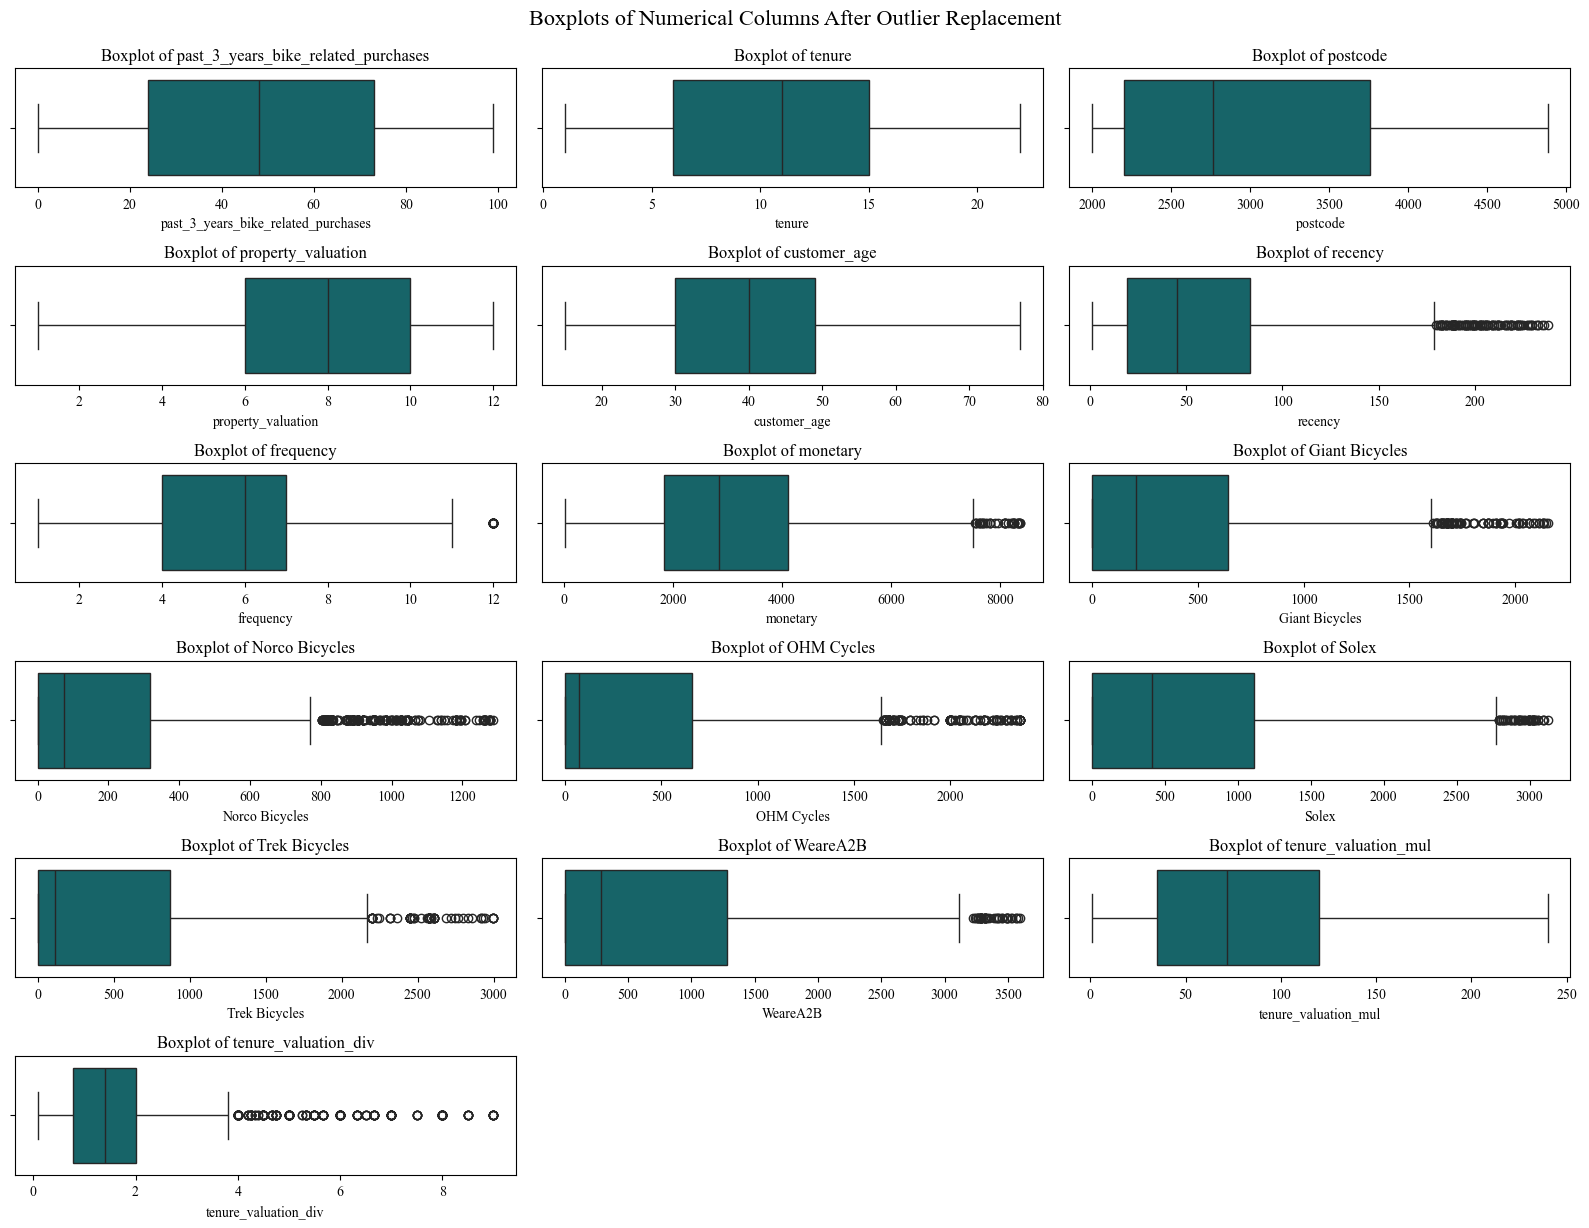

In [35]:
numerical_columns = customerdata_merge_df.select_dtypes(include=['float64', 'int64']).columns

num_cols = len(numerical_columns)
cols = 3  
rows = (num_cols + cols - 1) // cols  

plt.figure(figsize=(16, 2 * rows))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=customerdata_merge_df[col], color='#0A7075', orient='h')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.tight_layout()

plt.suptitle('Boxplots of Numerical Columns After Outlier Replacement', fontsize=16, y=1.02)
plt.show()

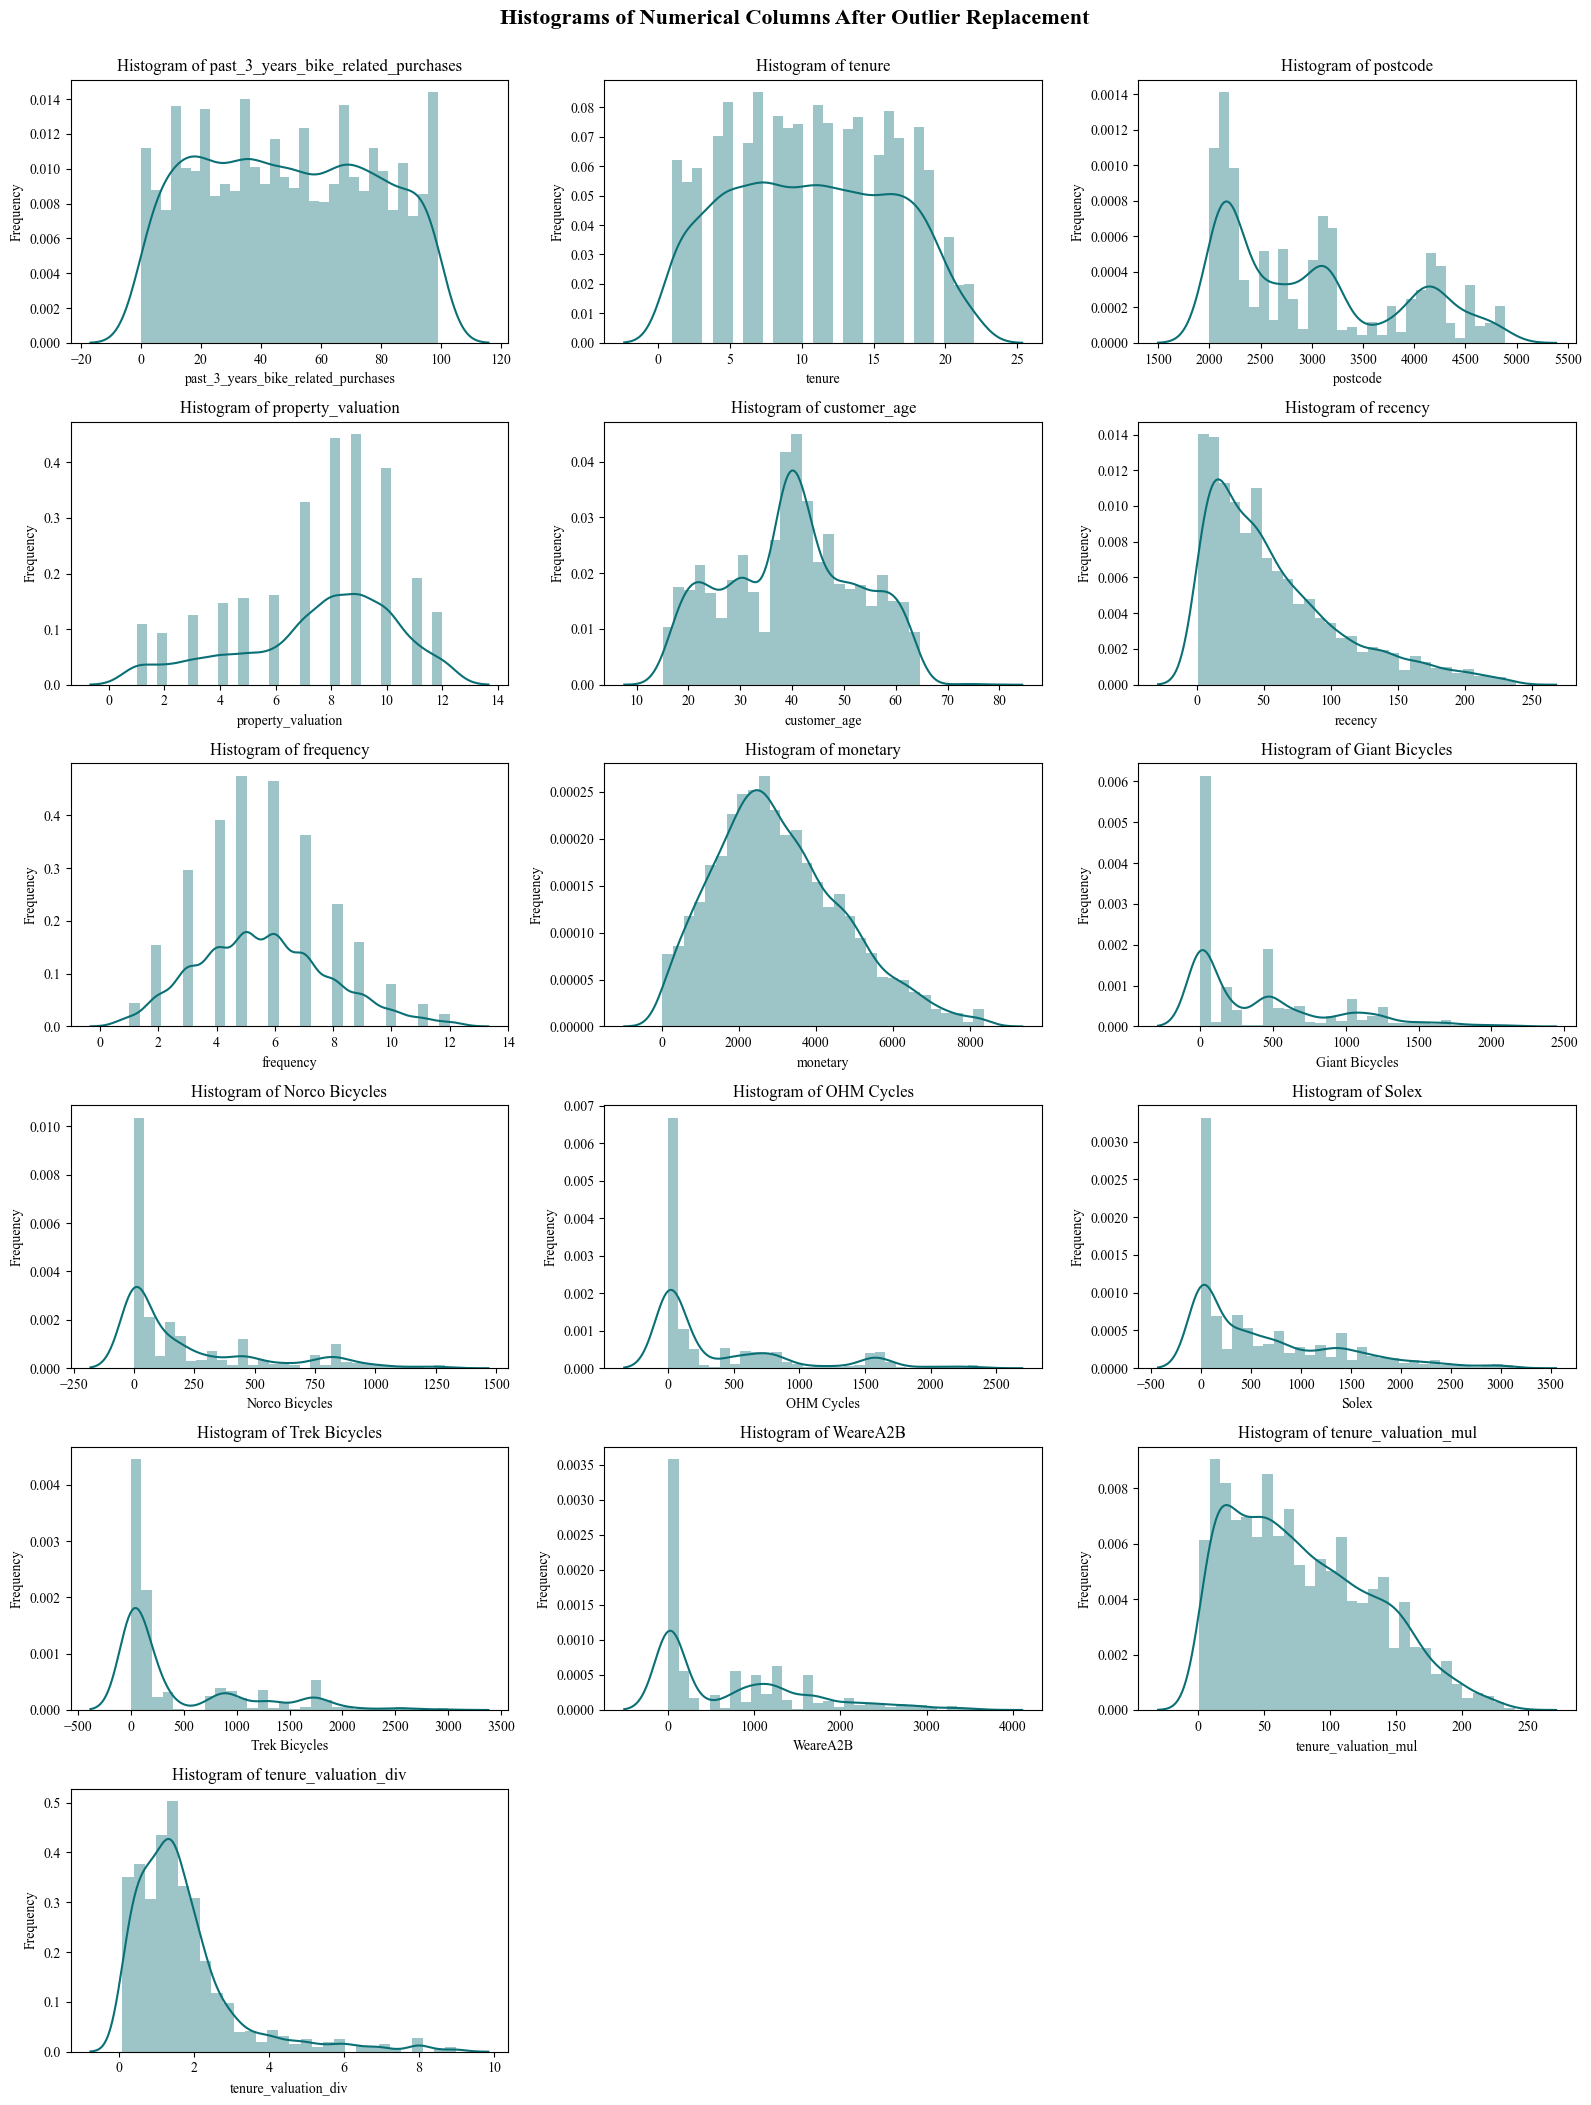

In [36]:
plt.figure(figsize=(16, 3.5 * rows))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)    
    sns.distplot(customerdata_merge_df[col], bins=30, kde=True, color='#0A7075')
    plt.title(f'Histogram of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Histograms of Numerical Columns After Outlier Replacement', fontsize=16,  fontweight = 'bold', y=1)
plt.tight_layout()
plt.show()


In [37]:
data_rfm = customerdata_merge_df.copy()

In [38]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3412 non-null   object        
 1   first_name                           3412 non-null   object        
 2   last_name                            3412 non-null   object        
 3   gender                               3412 non-null   object        
 4   past_3_years_bike_related_purchases  3412 non-null   float64       
 5   DOB                                  3412 non-null   datetime64[ns]
 6   job_title                            3412 non-null   object        
 7   job_industry_category                3412 non-null   object        
 8   wealth_segment                       3412 non-null   object        
 9   deceased_indicator                   3412 non-null   object        
 10  owns_car    

## 2.1. Data Pre-Processing

In [39]:
data_rfm.drop(['first_name','last_name', 'DOB', 'deceased_indicator', 'address','postcode','country', 'job_title'], axis=1, inplace=True)

In [40]:
numerical_columns=data_rfm.select_dtypes(include=('int64','float64'))

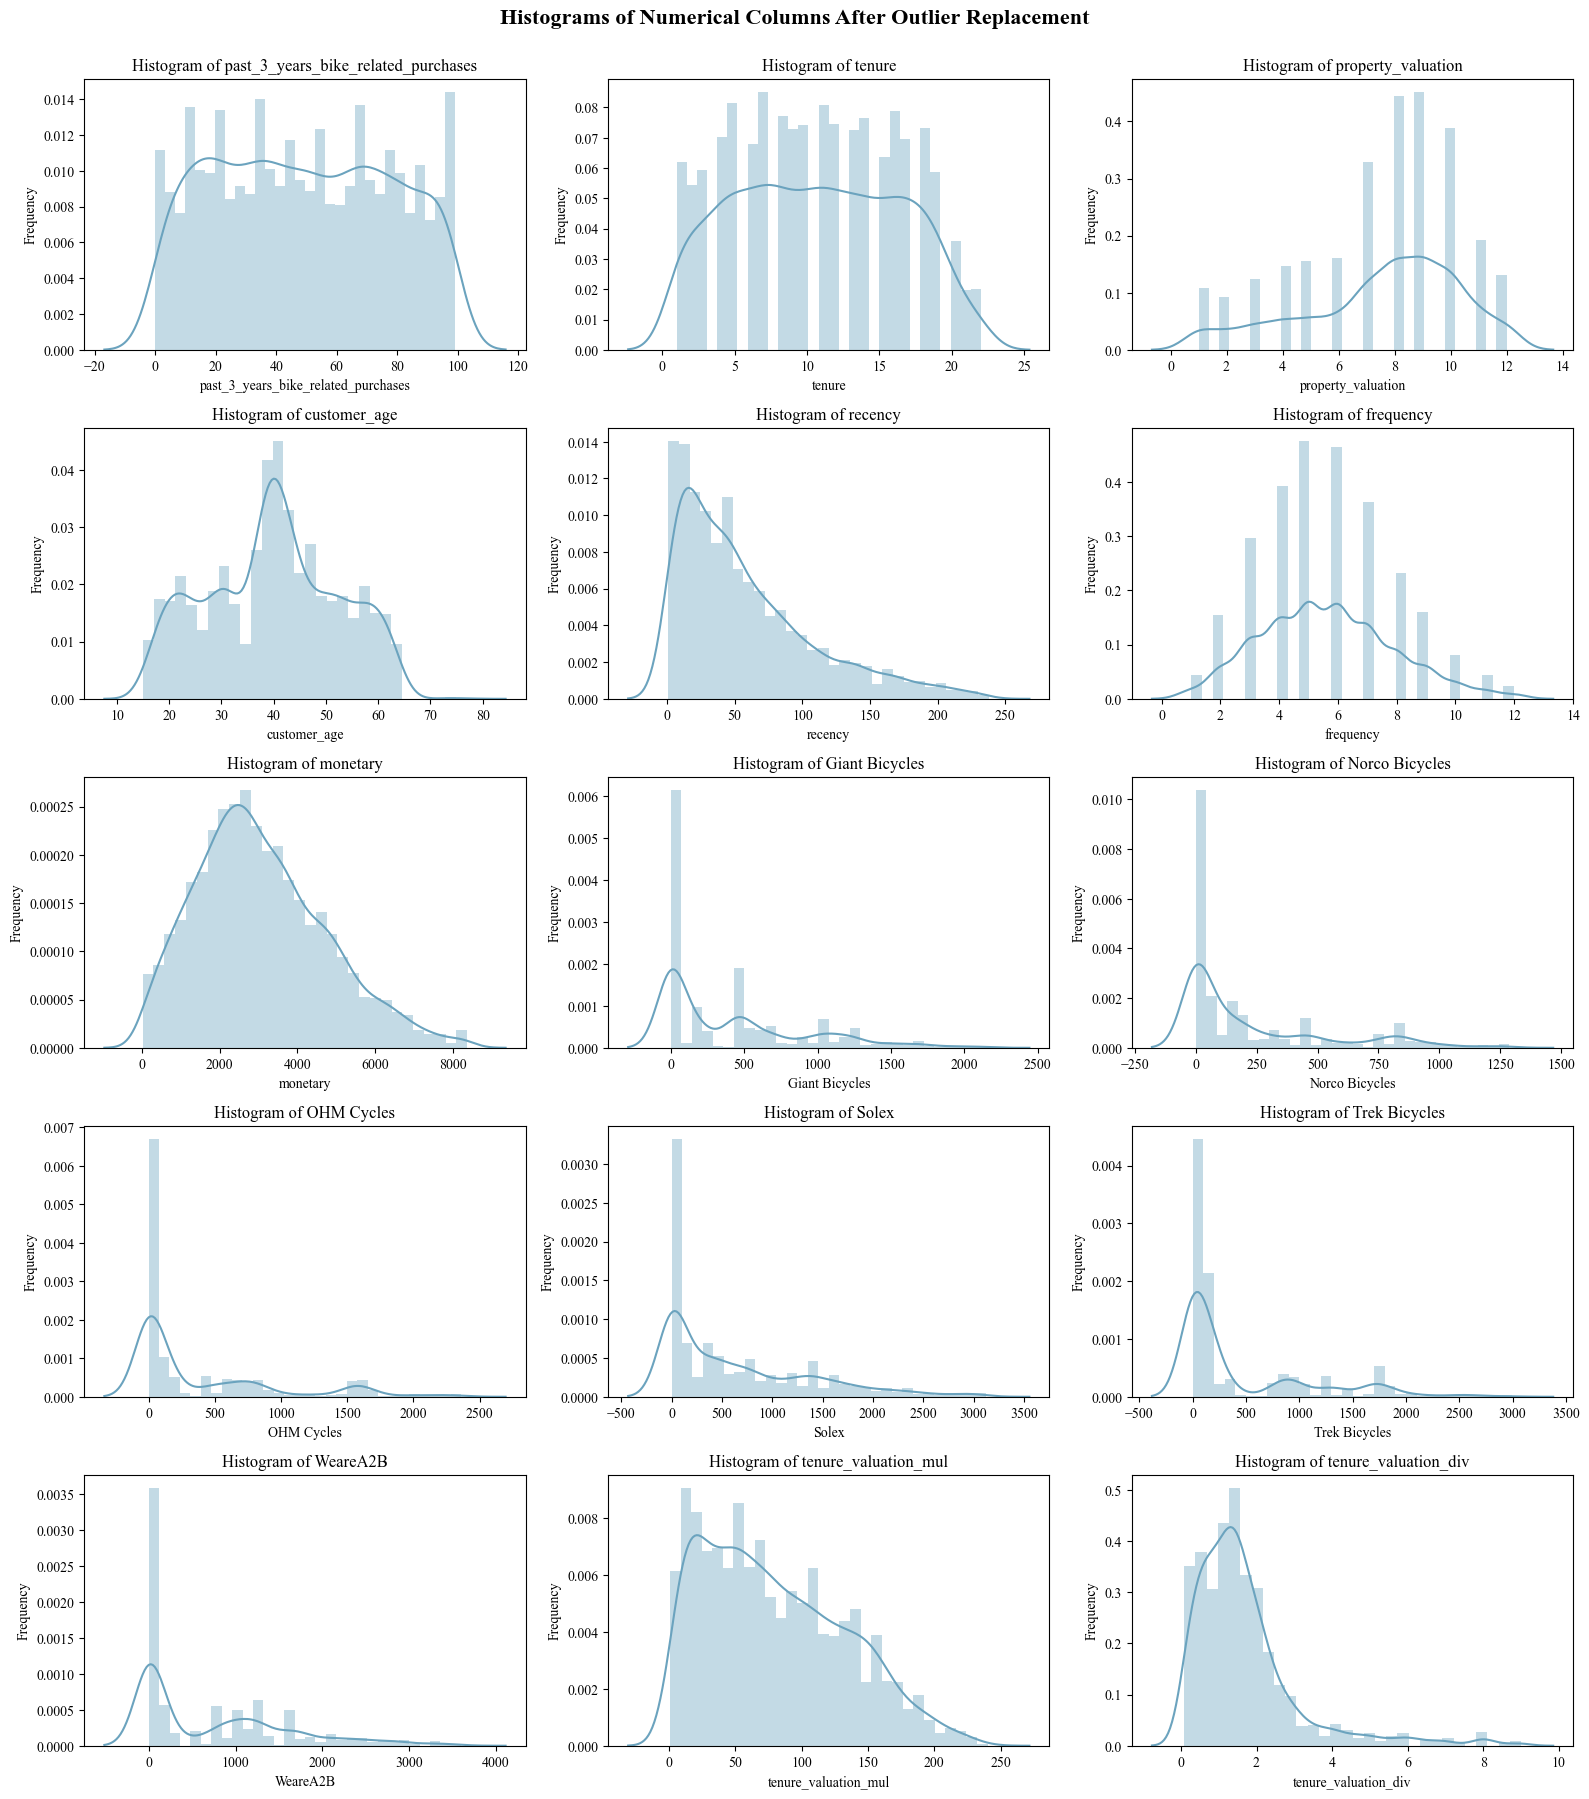

In [41]:
plt.figure(figsize=(16, 3.5 * rows))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)    
    sns.distplot(data_rfm[col], bins=30, kde=True, color='#6BA3BE')
    plt.title(f'Histogram of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Histograms of Numerical Columns After Outlier Replacement', fontsize=16,  fontweight = 'bold', y=1)
plt.tight_layout()
plt.show()

In [42]:
def calculate_skewness(df):
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    skew_vals = df[num_cols].apply(lambda x: skew(x.dropna()))

    skew_df = pd.DataFrame({
        'Variable': skew_vals.index,
        'Skewness': skew_vals.values
    }).sort_values(by='Skewness', key=abs, ascending=False).reset_index(drop=True)
    
    return skew_df
calculate_skewness(data_rfm)

,Variable,Skewness
0,tenure_valuation_div,2.226960
1,OHM Cycles,1.549574
2,Trek Bicycles,1.520378
3,Norco Bicycles,1.444631
4,recency,1.201606
5,Giant Bicycles,1.183909
6,Solex,1.142620
7,WeareA2B,1.025955
8,property_valuation,-0.640877
9,monetary,0.567529


In [43]:
def best_skew_fix(data, threshold=0.5):
    result = []
    num_cols = data.select_dtypes(include=['float64', 'int64']).columns

    for col in num_cols:
        original = data[col]
        orig_skew = skew(original.dropna())

        if abs(orig_skew) > threshold:
            transformations = {}

            # Log1p
            try:
                log_skew = skew(np.log1p(original[original >= 0]))
                transformations['log1p'] = log_skew
            except:
                transformations['log1p'] = np.nan

            # Sqrt
            try:
                sqrt_skew = skew(np.sqrt(original[original >= 0]))
                transformations['sqrt'] = sqrt_skew
            except:
                transformations['sqrt'] = np.nan

            # Box-Cox ---
            try:
                boxcox_skew = skew(boxcox(original[original > 0])[0])
                transformations['boxcox'] = boxcox_skew
            except:
                transformations['boxcox'] = np.nan

            best_method = min(transformations, key=lambda k: abs(transformations[k]) if pd.notnull(transformations[k]) else np.inf)
            best_skew = transformations[best_method]

            result.append({
                'Column': col,
                'Original_Skew': orig_skew,
                'Best_Method': best_method,
                'Transformed_Skew': best_skew
            })

    return pd.DataFrame(result)


In [44]:
best_skew_fix(data_rfm, threshold=0.5)

,Column,Original_Skew,Best_Method,Transformed_Skew
0,property_valuation,-0.640877,sqrt,-1.166973
1,recency,1.201606,sqrt,0.353178
2,monetary,0.567529,sqrt,-0.233037
3,Giant Bicycles,1.183909,sqrt,0.313605
4,Norco Bicycles,1.444631,log1p,-0.067295
5,OHM Cycles,1.549574,log1p,0.016432
6,Solex,1.142620,sqrt,0.208495
7,Trek Bicycles,1.520378,log1p,-0.100595
8,WeareA2B,1.025955,log1p,-0.268530
9,tenure_valuation_mul,0.521445,sqrt,-0.105831


In [45]:
from scipy.stats import boxcox
skew_fixes = best_skew_fix(data_rfm)

data_rfm_transformed = data_rfm.copy()

for _, row in skew_fixes.iterrows():
    col = row['Column']
    method = row['Best_Method']

    if method == 'log1p':
        data_rfm_transformed[col] = np.log1p(data_rfm_transformed[col])
    elif method == 'sqrt':
        data_rfm_transformed[col] = np.sqrt(data_rfm_transformed[col])
    elif method == 'boxcox':
        positive_data = data_rfm_transformed[col][data_rfm_transformed[col] > 0]
        if not positive_data.empty:
            transformed, _ = boxcox(positive_data)
            data_rfm_transformed.loc[positive_data.index, col] = transformed


In [46]:
new_skew_df = calculate_skewness(data_rfm_transformed)
new_skew_df

,Variable,Skewness
0,WeareA2B,0.387582
1,frequency,0.336369
2,property_valuation,-0.301516
3,Giant Bicycles,0.183788
4,tenure_valuation_mul,-0.105831
5,Trek Bicycles,-0.085983
6,recency,-0.073438
7,Solex,0.066276
8,monetary,-0.055527
9,tenure,0.051190


In [47]:
data_rfm_transformed

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,...,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,1,Female,93.0,Health,Mass Customer,Yes,11.0,NSW,17.184954,64.0,...,11.0,195.780257,46.479727,6.291215,5.229503,34.854612,5.402990,0.000000,10.488088,0.096277
1,2,Male,81.0,Financial Services,Mass Customer,Yes,16.0,NSW,17.184954,37.0,...,3.0,163.085934,26.207375,0.000000,0.000000,0.000000,0.000000,118.701780,12.649111,0.494148
2,4,Male,33.0,IT,Mass Customer,No,7.0,QLD,14.732525,56.0,...,2.0,39.970704,8.547586,0.000000,0.000000,18.080577,0.000000,0.000000,7.937254,-0.244755
3,5,Female,56.0,Others,Affluent Customer,Yes,8.0,NSW,4.254600,40.0,...,6.0,170.401870,40.457829,7.595083,0.000000,30.651310,4.432134,25.687301,5.656854,0.746510
4,6,Male,35.0,Retail,High Net Worth,Yes,13.0,VIC,14.732525,51.0,...,5.0,229.936869,38.780384,0.000000,0.000000,0.000000,5.108484,150.382671,10.816654,0.382397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Male,99.0,Manufacturing,Mass Customer,Yes,19.0,NSW,14.732525,31.0,...,4.0,155.007430,0.000000,7.292929,0.000000,48.105248,4.874879,0.000000,13.076697,0.809469
3408,3497,Female,73.0,Manufacturing,Affluent Customer,Yes,18.0,VIC,6.074740,31.0,...,3.0,136.110686,44.054663,0.000000,0.000000,16.298580,0.000000,0.000000,9.486833,1.471157
3409,3498,Female,28.0,Manufacturing,Mass Customer,No,5.0,VIC,4.254600,22.0,...,6.0,200.767231,0.000000,0.000000,6.125668,45.731220,5.108484,90.779576,4.472136,0.228491
3410,3499,Male,29.0,Manufacturing,Mass Customer,Yes,7.0,QLD,14.732525,38.0,...,7.0,263.517313,35.074781,6.303427,0.000000,31.630135,0.000000,168.716609,7.937254,-0.244755


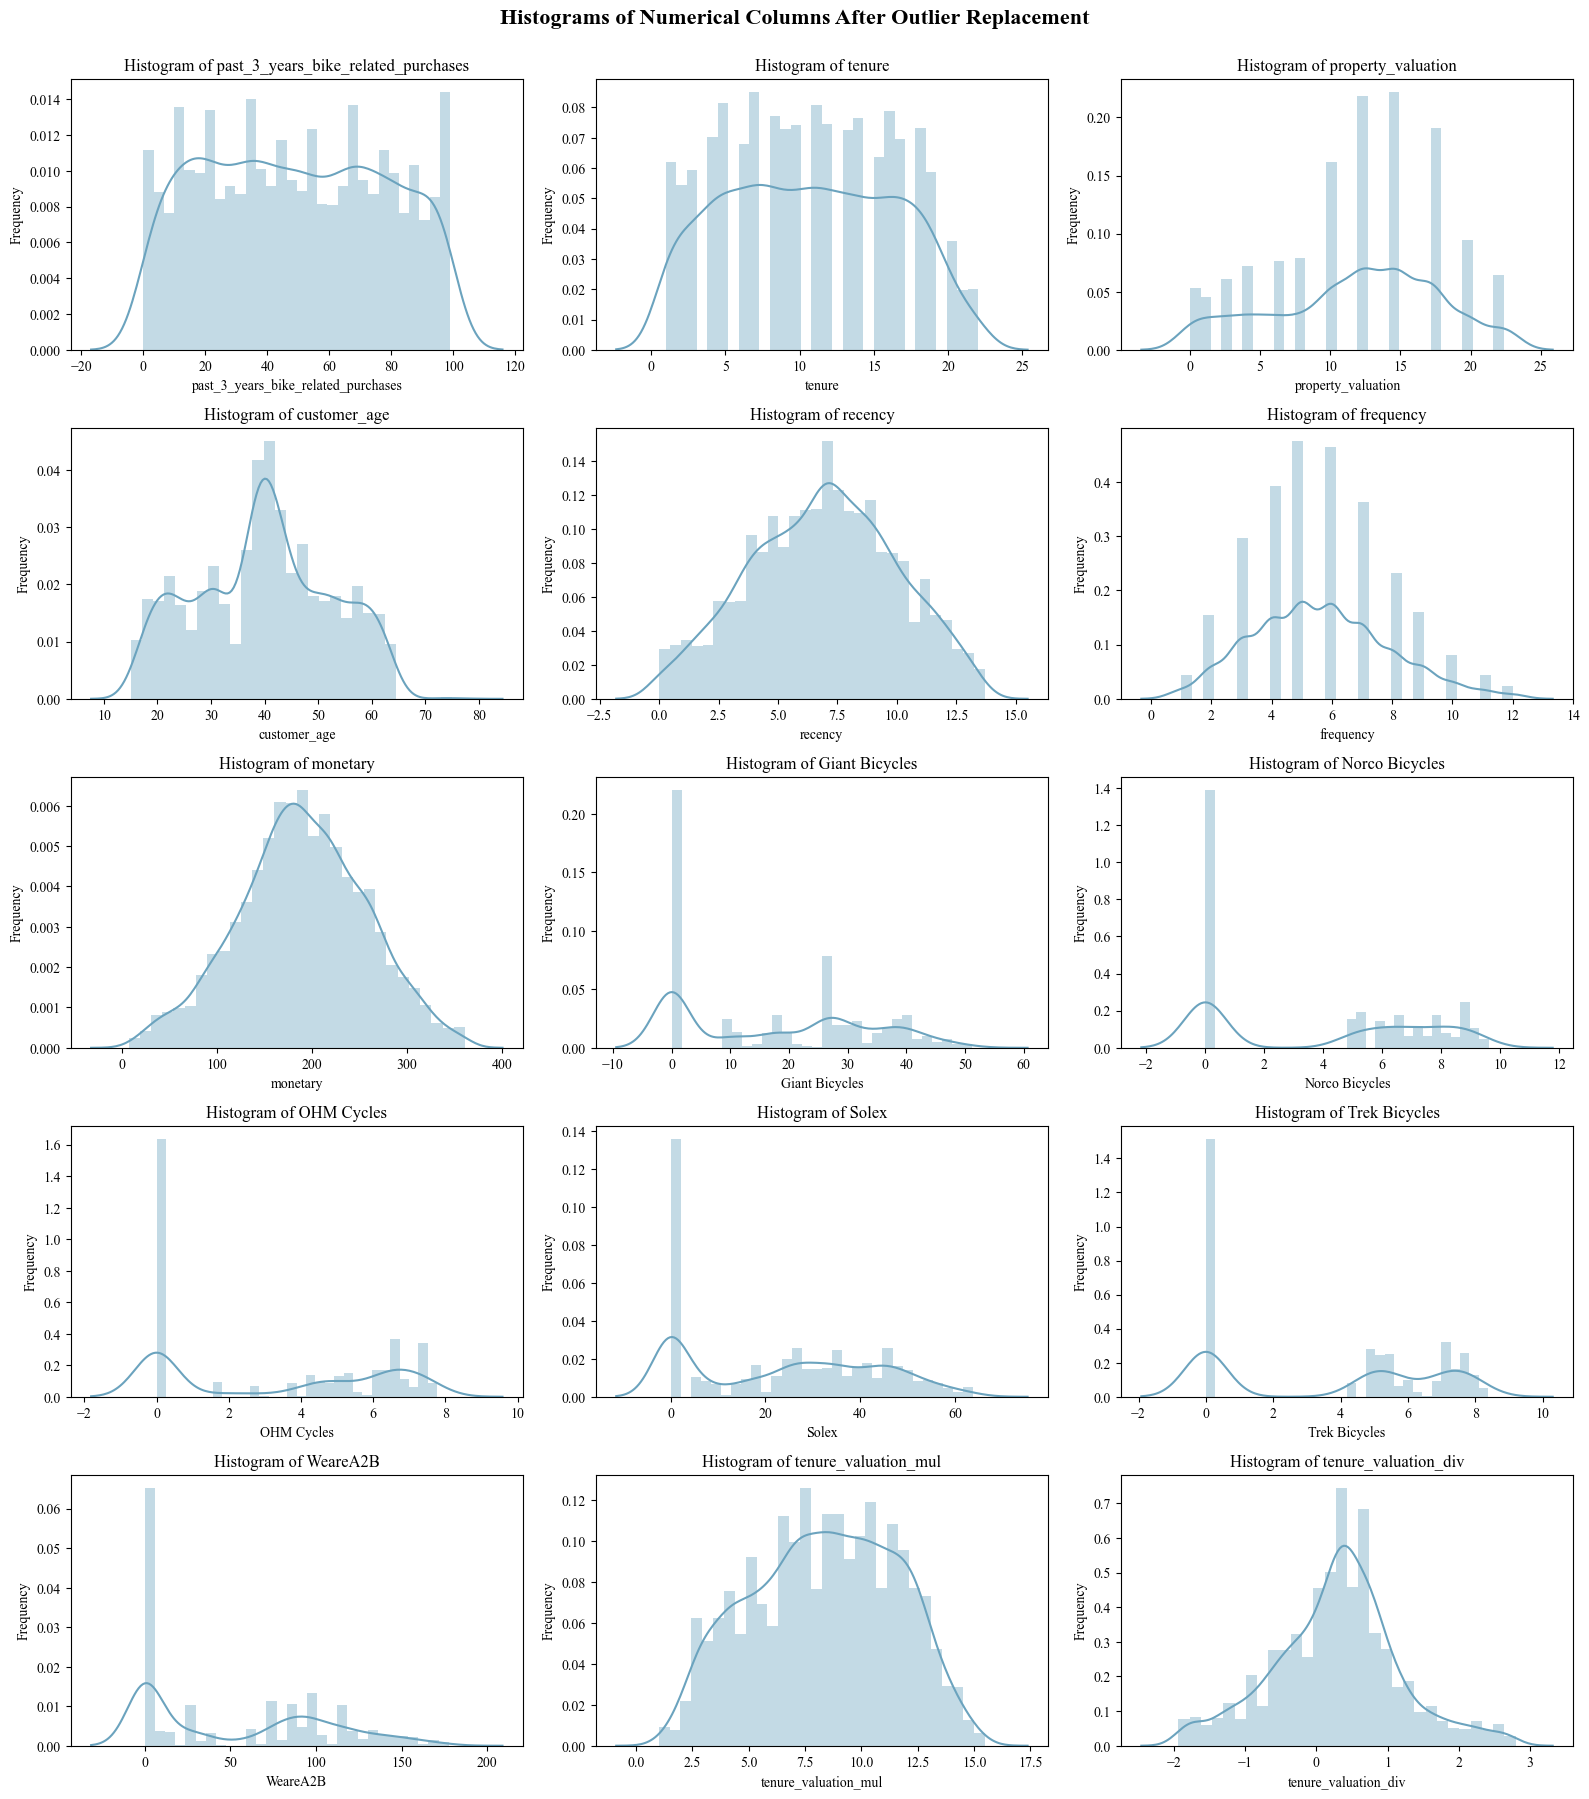

In [48]:
plt.figure(figsize=(16, 3.5 * rows))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(rows, cols, i)    
    sns.distplot(data_rfm_transformed[col], bins=30, kde=True, color='#6BA3BE')
    plt.title(f'Histogram of {col}', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Histograms of Numerical Columns After Outlier Replacement', fontsize=16, fontweight = 'bold', y=1)
plt.tight_layout()
plt.show()

In [49]:
data_rfm=data_rfm_transformed.copy()

In [50]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3412 non-null   object 
 1   gender                               3412 non-null   object 
 2   past_3_years_bike_related_purchases  3412 non-null   float64
 3   job_industry_category                3412 non-null   object 
 4   wealth_segment                       3412 non-null   object 
 5   owns_car                             3412 non-null   object 
 6   tenure                               3412 non-null   float64
 7   state                                3412 non-null   object 
 8   property_valuation                   3412 non-null   float64
 9   customer_age                         3412 non-null   float64
 10  recency                              3412 non-null   float64
 11  frequency                     

In [51]:
data_rfm.select_dtypes(include='object').columns

Index(['customer_id', 'gender', 'job_industry_category', 'wealth_segment',
       'owns_car', 'state'],
      dtype='object')

In [52]:
category_cols=['gender', 'job_industry_category',
       'wealth_segment', 'owns_car', 'state']

In [53]:
# Convert all object data type columns to categorical features
for col in category_cols:
    data_rfm[col] = data_rfm[col].astype('category')

In [54]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   customer_id                          3412 non-null   object  
 1   gender                               3412 non-null   category
 2   past_3_years_bike_related_purchases  3412 non-null   float64 
 3   job_industry_category                3412 non-null   category
 4   wealth_segment                       3412 non-null   category
 5   owns_car                             3412 non-null   category
 6   tenure                               3412 non-null   float64 
 7   state                                3412 non-null   category
 8   property_valuation                   3412 non-null   float64 
 9   customer_age                         3412 non-null   float64 
 10  recency                              3412 non-null   float64 
 11  frequency        

In [55]:
data_rfm['customer_id']=data_rfm['customer_id'].astype('int64')

In [56]:
for col in category_cols:
    print(data_rfm[col].value_counts())

gender
Female    1758
Male      1654
Name: count, dtype: int64
job_industry_category
Manufacturing         701
Financial Services    679
Others                560
Health                526
Retail                304
Property              230
IT                    126
Entertainment         123
Argiculture           100
Telecommunications     63
Name: count, dtype: int64
wealth_segment
Mass Customer        1702
High Net Worth        873
Affluent Customer     837
Name: count, dtype: int64
owns_car
Yes    1723
No     1689
Name: count, dtype: int64
state
NSW    1824
VIC     860
QLD     728
Name: count, dtype: int64


In [57]:
data_rfm['job_industry_category'].value_counts()

job_industry_category
Manufacturing         701
Financial Services    679
Others                560
Health                526
Retail                304
Property              230
IT                    126
Entertainment         123
Argiculture           100
Telecommunications     63
Name: count, dtype: int64

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
label_encoder = LabelEncoder()

for col in data_rfm.select_dtypes(include=['category']).columns:
    data_rfm[col] = label_encoder.fit_transform(data_rfm[col])
for col in data_rfm.select_dtypes(include = ['bool']).columns:
    data_rfm[col] = data_rfm[col].astype('int')

data_rfm.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,...,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,1,0,93.0,3,2,1,11.0,0,17.184954,64.0,...,11.0,195.780257,46.479727,6.291215,5.229503,34.854612,5.402990,0.000000,10.488088,0.096277
1,2,1,81.0,2,2,1,16.0,0,17.184954,37.0,...,3.0,163.085934,26.207375,0.000000,0.000000,0.000000,0.000000,118.701780,12.649111,0.494148
2,4,1,33.0,4,2,0,7.0,1,14.732525,56.0,...,2.0,39.970704,8.547586,0.000000,0.000000,18.080577,0.000000,0.000000,7.937254,-0.244755
3,5,0,56.0,6,0,1,8.0,0,4.254600,40.0,...,6.0,170.401870,40.457829,7.595083,0.000000,30.651310,4.432134,25.687301,5.656854,0.746510
4,6,1,35.0,8,1,1,13.0,2,14.732525,51.0,...,5.0,229.936869,38.780384,0.000000,0.000000,0.000000,5.108484,150.382671,10.816654,0.382397


In [60]:
data_rfm

,customer_id,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,...,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,1,0,93.0,3,2,1,11.0,0,17.184954,64.0,...,11.0,195.780257,46.479727,6.291215,5.229503,34.854612,5.402990,0.000000,10.488088,0.096277
1,2,1,81.0,2,2,1,16.0,0,17.184954,37.0,...,3.0,163.085934,26.207375,0.000000,0.000000,0.000000,0.000000,118.701780,12.649111,0.494148
2,4,1,33.0,4,2,0,7.0,1,14.732525,56.0,...,2.0,39.970704,8.547586,0.000000,0.000000,18.080577,0.000000,0.000000,7.937254,-0.244755
3,5,0,56.0,6,0,1,8.0,0,4.254600,40.0,...,6.0,170.401870,40.457829,7.595083,0.000000,30.651310,4.432134,25.687301,5.656854,0.746510
4,6,1,35.0,8,1,1,13.0,2,14.732525,51.0,...,5.0,229.936869,38.780384,0.000000,0.000000,0.000000,5.108484,150.382671,10.816654,0.382397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,1,99.0,5,2,1,19.0,0,14.732525,31.0,...,4.0,155.007430,0.000000,7.292929,0.000000,48.105248,4.874879,0.000000,13.076697,0.809469
3408,3497,0,73.0,5,0,1,18.0,2,6.074740,31.0,...,3.0,136.110686,44.054663,0.000000,0.000000,16.298580,0.000000,0.000000,9.486833,1.471157
3409,3498,0,28.0,5,2,0,5.0,2,4.254600,22.0,...,6.0,200.767231,0.000000,0.000000,6.125668,45.731220,5.108484,90.779576,4.472136,0.228491
3410,3499,1,29.0,5,2,1,7.0,1,14.732525,38.0,...,7.0,263.517313,35.074781,6.303427,0.000000,31.630135,0.000000,168.716609,7.937254,-0.244755


In [61]:
data_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3412 entries, 0 to 3411
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3412 non-null   int64  
 1   gender                               3412 non-null   int64  
 2   past_3_years_bike_related_purchases  3412 non-null   float64
 3   job_industry_category                3412 non-null   int64  
 4   wealth_segment                       3412 non-null   int64  
 5   owns_car                             3412 non-null   int64  
 6   tenure                               3412 non-null   float64
 7   state                                3412 non-null   int64  
 8   property_valuation                   3412 non-null   float64
 9   customer_age                         3412 non-null   float64
 10  recency                              3412 non-null   float64
 11  frequency                     

In [62]:
ds=data_rfm.select_dtypes(include=['int64', 'float64'])

In [63]:
ds.drop('customer_id', inplace=True, axis=1)

In [64]:
ds

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,0,93.0,3,2,1,11.0,0,17.184954,64.0,2.874211,11.0,195.780257,46.479727,6.291215,5.229503,34.854612,5.402990,0.000000,10.488088,0.096277
1,1,81.0,2,2,1,16.0,0,17.184954,37.0,10.864674,3.0,163.085934,26.207375,0.000000,0.000000,0.000000,0.000000,118.701780,12.649111,0.494148
2,1,33.0,4,2,0,7.0,1,14.732525,56.0,12.742887,2.0,39.970704,8.547586,0.000000,0.000000,18.080577,0.000000,0.000000,7.937254,-0.244755
3,0,56.0,6,0,1,8.0,0,4.254600,40.0,4.437637,6.0,170.401870,40.457829,7.595083,0.000000,30.651310,4.432134,25.687301,5.656854,0.746510
4,1,35.0,8,1,1,13.0,2,14.732525,51.0,8.248294,5.0,229.936869,38.780384,0.000000,0.000000,0.000000,5.108484,150.382671,10.816654,0.382397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,1,99.0,5,2,1,19.0,0,14.732525,31.0,7.048783,4.0,155.007430,0.000000,7.292929,0.000000,48.105248,4.874879,0.000000,13.076697,0.809469
3408,0,73.0,5,0,1,18.0,2,6.074740,31.0,7.566443,3.0,136.110686,44.054663,0.000000,0.000000,16.298580,0.000000,0.000000,9.486833,1.471157
3409,0,28.0,5,2,0,5.0,2,4.254600,22.0,10.831889,6.0,200.767231,0.000000,0.000000,6.125668,45.731220,5.108484,90.779576,4.472136,0.228491
3410,1,29.0,5,2,1,7.0,1,14.732525,38.0,7.504884,7.0,263.517313,35.074781,6.303427,0.000000,31.630135,0.000000,168.716609,7.937254,-0.244755


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns)

In [66]:
scaled_ds

,gender,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,-0.96997,1.536898,-0.633489,0.905332,0.990084,0.056682,-0.853396,0.910642,1.931137,-1.319766,2.383491,0.091414,1.790644,0.633876,0.618181,0.551009,0.539562,-1.004997,0.674305,-0.214743
1,1.03096,1.118012,-1.083701,0.905332,0.990084,0.938170,-0.853396,0.910642,-0.223343,1.290944,-1.167806,-0.396121,0.527319,-1.072501,-1.083917,-1.242112,-1.122467,1.219429,1.350001,0.235817
2,1.03096,-0.557533,-0.183278,0.905332,-1.010015,-0.648508,0.336060,0.494913,1.292773,1.904609,-1.611718,-2.232007,-0.573197,-1.072501,-1.083917,-0.311943,-1.122467,-1.004997,-0.123275,-0.600936
3,-0.96997,0.245332,0.717145,-1.520261,0.990084,-0.472211,-0.853396,-1.281275,0.016043,-0.808951,0.163930,-0.287027,1.415374,0.987527,-1.083917,0.334767,0.240914,-0.523627,-0.836298,0.521598
4,1.03096,-0.487718,1.617569,-0.307464,0.990084,0.409277,1.525516,0.494913,0.893795,0.436098,-0.279982,0.600755,1.310839,-1.072501,-1.083917,-1.242112,0.448968,1.813117,0.777039,0.109266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,1.03096,1.746341,0.266934,0.905332,0.990084,1.467062,-0.853396,0.494913,-0.702117,0.044184,-0.723894,-0.516587,-1.105862,0.905573,-1.083917,1.232698,0.377108,-1.004997,1.483696,0.592895
3408,-0.96997,0.838755,0.266934,-1.520261,0.990084,1.290765,1.525516,-0.972730,-0.702117,0.213319,-1.167806,-0.798374,1.639520,-1.072501,-1.083917,-0.403619,-1.122467,-1.004997,0.361238,1.342207
3409,-0.96997,-0.732069,0.266934,0.905332,-1.010015,-1.001103,1.525516,-1.281275,-1.420277,1.280232,0.163930,0.165779,-1.105862,-1.072501,0.909865,1.110565,0.448968,0.696178,-1.206729,-0.065021
3410,1.03096,-0.697162,0.266934,0.905332,0.990084,-0.648508,0.336060,0.494913,-0.143548,0.193206,0.607842,1.101504,1.079915,0.637189,-1.083917,0.385124,-1.122467,2.156688,-0.123275,-0.600936


In [67]:
scaled_ds_columns=scaled_ds.columns

In [68]:
scaled_ds_columns

Index(['gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'customer_age', 'recency', 'frequency',
       'monetary', 'Giant Bicycles', 'Norco Bicycles', 'OHM Cycles', 'Solex',
       'Trek Bicycles', 'WeareA2B', 'tenure_valuation_mul',
       'tenure_valuation_div'],
      dtype='object')

In [69]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## principal conponent analysis

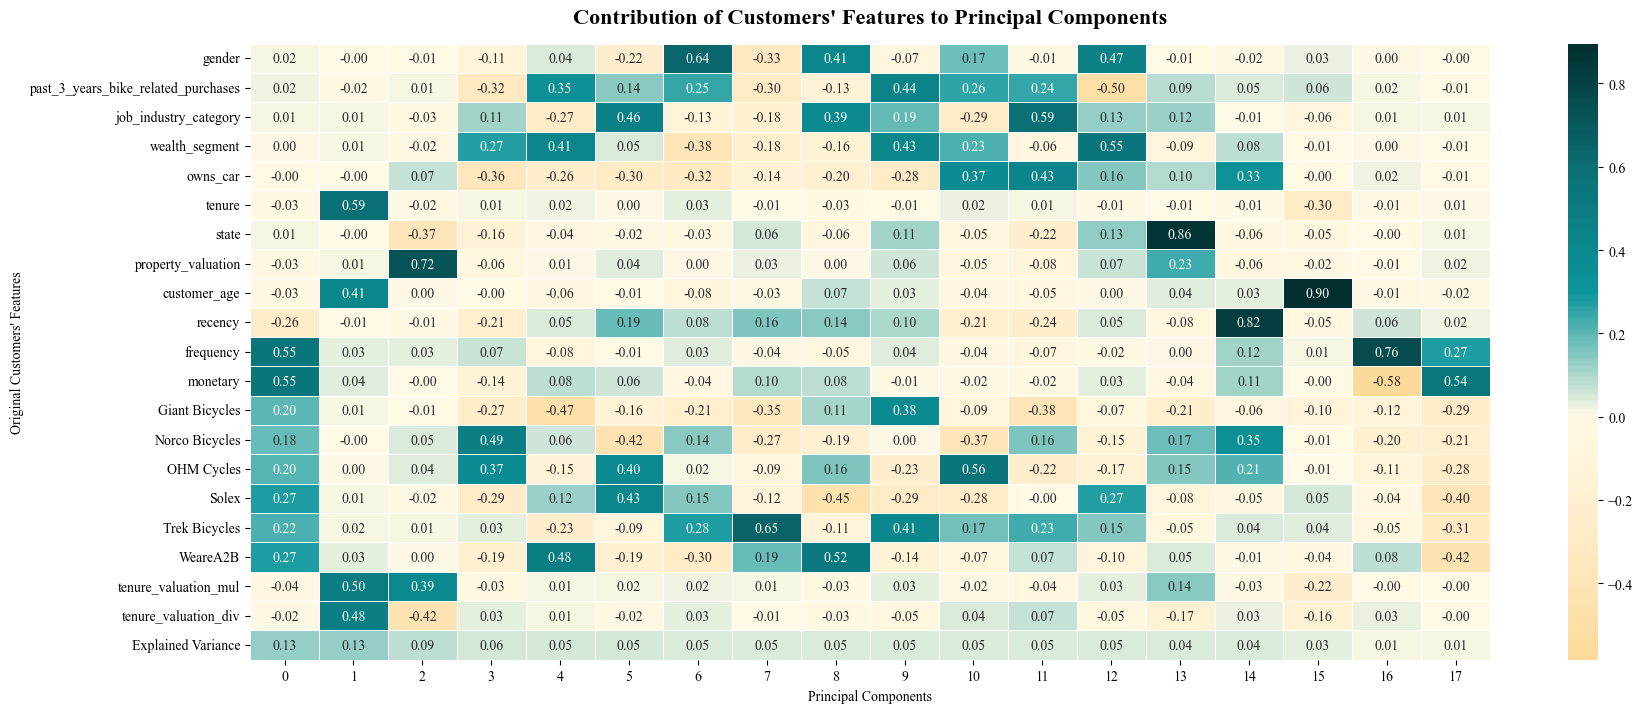

In [70]:
optimal_components = 18
pca = PCA(n_components = optimal_components)
data_pca = pca.fit_transform(scaled_ds)

feature_names = scaled_ds_columns
pca_df = pd.DataFrame(pca.components_, columns=feature_names)

explained_variance = pca.explained_variance_ratio_

pca_df_with_variance = pd.DataFrame(pca.components_, columns=feature_names)
pca_df_with_variance['Explained Variance'] = explained_variance

plt.figure(figsize=(20, 8))
sns.heatmap(pca_df_with_variance.T, annot=True, cmap=cmap_1, fmt='.2f', center=0, linecolor='white', linewidths=0.7)
plt.title("Contribution of Customers' Features to Principal Components", fontsize=16, fontweight='bold', y=1.02)
plt.xlabel('Principal Components')
plt.ylabel("Original Customers' Features")
plt.show()

# 3. Customer Segment - Clustering - KMenas Method

#

In [124]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_clustering(X, clustering_algo):
    clustering_algo.fit(X)
    labels = clustering_algo.labels_
    if len(set(labels)) == 1:
        return None, None, None  
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    calinski_harabasz = calinski_harabasz_score(X, labels)
    return silhouette, davies_bouldin, calinski_harabasz

# Evaluate KMeans
kmeans = KMeans(n_clusters=4, random_state=123)
kmeans_metrics = evaluate_clustering(data_pca, kmeans)

# Evaluate Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_metrics = evaluate_clustering(data_pca, hierarchical)

# Evaluate DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data_pca)
labels_dbscan = dbscan.labels_

if len(set(labels_dbscan)) > 1:
    dbscan_metrics = (
        silhouette_score(data_pca, labels_dbscan),
        davies_bouldin_score(data_pca, labels_dbscan),
        calinski_harabasz_score(data_pca, labels_dbscan)
    )
else:
    dbscan_metrics = ('Not applicable (only one cluster found)', ) * 3


results = {
    'Clustering Method': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [kmeans_metrics[0], hierarchical_metrics[0], dbscan_metrics[0]],
    'Davies-Bouldin Index': [kmeans_metrics[1], hierarchical_metrics[1], dbscan_metrics[1]],
    'Calinski-Harabasz Index': [kmeans_metrics[2], hierarchical_metrics[2], dbscan_metrics[2]],
}

results_df = pd.DataFrame(results)
results_df

,Clustering Method,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,KMeans,0.078736,2.636502,266.82624
1,Hierarchical,0.041942,3.429804,175.918898
2,DBSCAN,Not applicable (only one cluster found),Not applicable (only one cluster found),Not applicable (only one cluster found)


Dựa trên các chỉ số đánh giá, KMeans là phương pháp tốt nhất trong ba lựa chọn, dù hiệu quả vẫn chưa cao (Silhouette Score thấp và Davies-Bouldin Index khá lớn). Hierarchical clustering cho kết quả kém hơn với các chỉ số thấp hơn. DBSCAN không hiệu quả vì chỉ tìm được một cụm, có thể do tham số chưa phù hợp.
👉 Gợi ý: Nên tiếp tục dùng KMeans và tối ưu thêm, hoặc điều chỉnh tham số để cải thiện DBSCAN

In [125]:
scaled_ds.columns

Index(['gender', 'past_3_years_bike_related_purchases',
       'job_industry_category', 'wealth_segment', 'owns_car', 'tenure',
       'state', 'property_valuation', 'customer_age', 'recency', 'frequency',
       'monetary', 'Giant Bicycles', 'Norco Bicycles', 'OHM Cycles', 'Solex',
       'Trek Bicycles', 'WeareA2B', 'tenure_valuation_mul',
       'tenure_valuation_div'],
      dtype='object')

In [126]:
selected_cols=['property_valuation','frequency','recency','tenure','customer_age',
       'monetary', 'Giant Bicycles', 'Norco Bicycles', 'OHM Cycles', 'Solex',
       'Trek Bicycles', 'WeareA2B','tenure_valuation_mul','tenure_valuation_div']

In [127]:
scaled_ds[selected_cols]

,property_valuation,frequency,recency,tenure,customer_age,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,0.910642,2.383491,-1.319766,0.056682,1.931137,0.091414,1.790644,0.633876,0.618181,0.551009,0.539562,-1.004997,0.674305,-0.214743
1,0.910642,-1.167806,1.290944,0.938170,-0.223343,-0.396121,0.527319,-1.072501,-1.083917,-1.242112,-1.122467,1.219429,1.350001,0.235817
2,0.494913,-1.611718,1.904609,-0.648508,1.292773,-2.232007,-0.573197,-1.072501,-1.083917,-0.311943,-1.122467,-1.004997,-0.123275,-0.600936
3,-1.281275,0.163930,-0.808951,-0.472211,0.016043,-0.287027,1.415374,0.987527,-1.083917,0.334767,0.240914,-0.523627,-0.836298,0.521598
4,0.494913,-0.279982,0.436098,0.409277,0.893795,0.600755,1.310839,-1.072501,-1.083917,-1.242112,0.448968,1.813117,0.777039,0.109266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,0.494913,-0.723894,0.044184,1.467062,-0.702117,-0.516587,-1.105862,0.905573,-1.083917,1.232698,0.377108,-1.004997,1.483696,0.592895
3408,-0.972730,-1.167806,0.213319,1.290765,-0.702117,-0.798374,1.639520,-1.072501,-1.083917,-0.403619,-1.122467,-1.004997,0.361238,1.342207
3409,-1.281275,0.163930,1.280232,-1.001103,-1.420277,0.165779,-1.105862,-1.072501,0.909865,1.110565,0.448968,0.696178,-1.206729,-0.065021
3410,0.494913,0.607842,0.193206,-0.648508,-0.143548,1.101504,1.079915,0.637189,-1.083917,0.385124,-1.122467,2.156688,-0.123275,-0.600936


In [140]:
PCA_ds = scaled_ds[selected_cols]

In [141]:
PCA_ds


,property_valuation,frequency,recency,tenure,customer_age,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
0,0.910642,2.383491,-1.319766,0.056682,1.931137,0.091414,1.790644,0.633876,0.618181,0.551009,0.539562,-1.004997,0.674305,-0.214743
1,0.910642,-1.167806,1.290944,0.938170,-0.223343,-0.396121,0.527319,-1.072501,-1.083917,-1.242112,-1.122467,1.219429,1.350001,0.235817
2,0.494913,-1.611718,1.904609,-0.648508,1.292773,-2.232007,-0.573197,-1.072501,-1.083917,-0.311943,-1.122467,-1.004997,-0.123275,-0.600936
3,-1.281275,0.163930,-0.808951,-0.472211,0.016043,-0.287027,1.415374,0.987527,-1.083917,0.334767,0.240914,-0.523627,-0.836298,0.521598
4,0.494913,-0.279982,0.436098,0.409277,0.893795,0.600755,1.310839,-1.072501,-1.083917,-1.242112,0.448968,1.813117,0.777039,0.109266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,0.494913,-0.723894,0.044184,1.467062,-0.702117,-0.516587,-1.105862,0.905573,-1.083917,1.232698,0.377108,-1.004997,1.483696,0.592895
3408,-0.972730,-1.167806,0.213319,1.290765,-0.702117,-0.798374,1.639520,-1.072501,-1.083917,-0.403619,-1.122467,-1.004997,0.361238,1.342207
3409,-1.281275,0.163930,1.280232,-1.001103,-1.420277,0.165779,-1.105862,-1.072501,0.909865,1.110565,0.448968,0.696178,-1.206729,-0.065021
3410,0.494913,0.607842,0.193206,-0.648508,-0.143548,1.101504,1.079915,0.637189,-1.083917,0.385124,-1.122467,2.156688,-0.123275,-0.600936


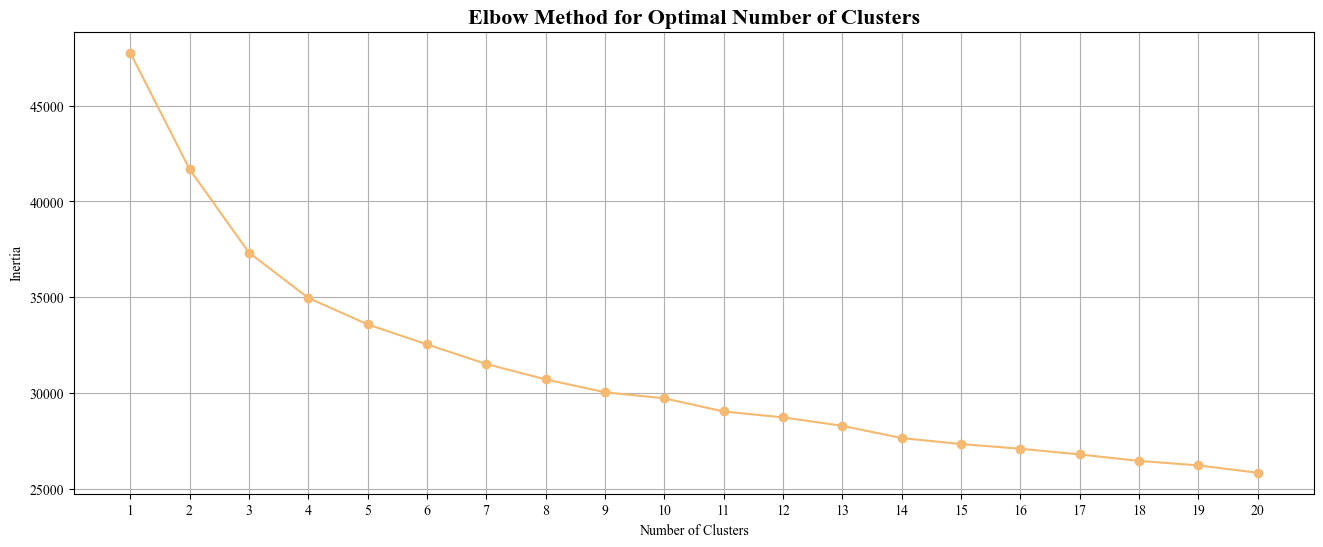

In [142]:
# ELBOW METHOD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def calculate_inertia(data, max_clusters):
    inertia = []
    for n in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=n, random_state=123)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    return inertia
max_clusters = 20
inertia = calculate_inertia(PCA_ds, max_clusters)

plt.figure(figsize=(16, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker = 'o', color='#f5b971')
plt.title('Elbow Method for Optimal Number of Clusters',  fontweight = 'bold', fontsize=16, y=1)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

In [143]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 123)
    kmeans.fit(normalised_df_rfm)
    cluster_labels = kmeans.labels_  
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    model = TSNE(random_state=123)
    transformed = model.fit_transform(df_new)
    
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number),  fontweight = 'bold', fontsize=14, y=1)
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette='pastel')
    
    return df_new

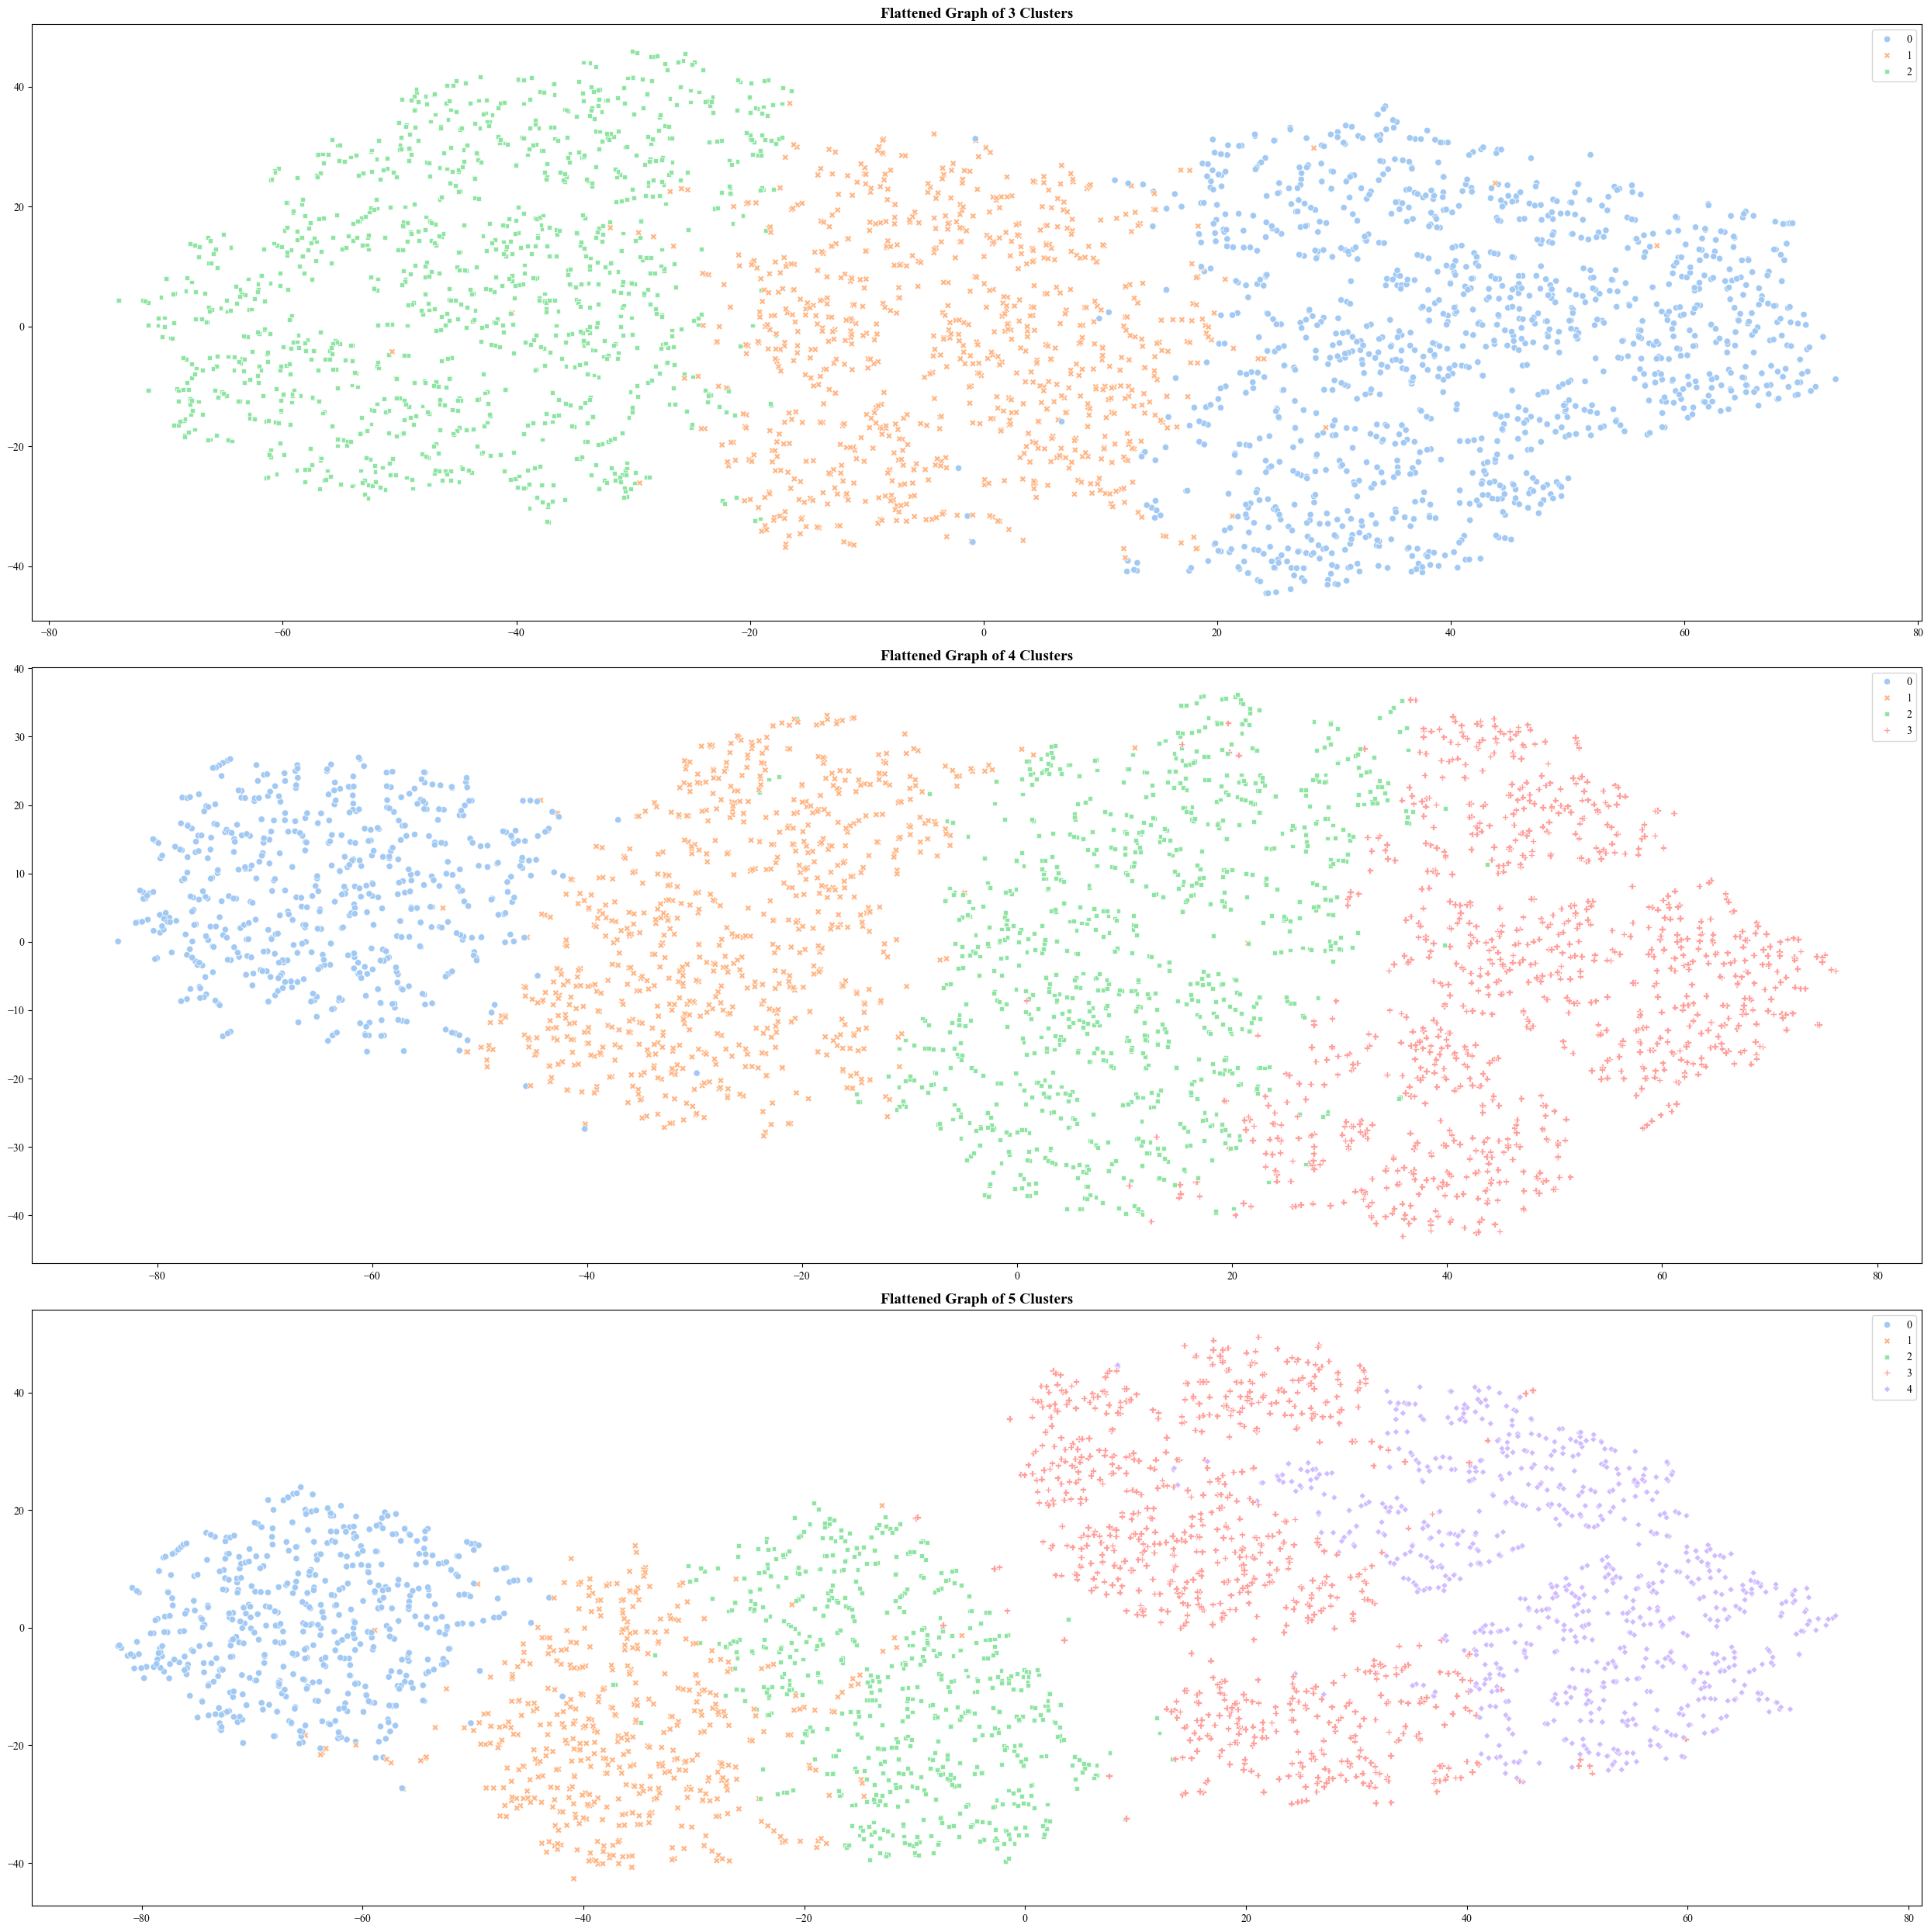

In [144]:
plt.figure(figsize=(25, 25))
plt.subplot(3, 1, 1)
df_rfm_k3 = kmeans(PCA_ds, 3, PCA_ds)
plt.subplot(3, 1, 2)
df_rfm_k4 = kmeans(PCA_ds, 4, PCA_ds)
plt.subplot(3, 1, 3)
df_rfm_k5 = kmeans(PCA_ds, 5, PCA_ds)
plt.tight_layout()
plt.show()

In [145]:
np.random.seed(123)
KM = KMeans(n_clusters=4, random_state = 123)

yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_KM

In [146]:
PCA_ds

,property_valuation,frequency,recency,tenure,customer_age,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div,Clusters
0,0.910642,2.383491,-1.319766,0.056682,1.931137,0.091414,1.790644,0.633876,0.618181,0.551009,0.539562,-1.004997,0.674305,-0.214743,3
1,0.910642,-1.167806,1.290944,0.938170,-0.223343,-0.396121,0.527319,-1.072501,-1.083917,-1.242112,-1.122467,1.219429,1.350001,0.235817,2
2,0.494913,-1.611718,1.904609,-0.648508,1.292773,-2.232007,-0.573197,-1.072501,-1.083917,-0.311943,-1.122467,-1.004997,-0.123275,-0.600936,2
3,-1.281275,0.163930,-0.808951,-0.472211,0.016043,-0.287027,1.415374,0.987527,-1.083917,0.334767,0.240914,-0.523627,-0.836298,0.521598,0
4,0.494913,-0.279982,0.436098,0.409277,0.893795,0.600755,1.310839,-1.072501,-1.083917,-1.242112,0.448968,1.813117,0.777039,0.109266,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,0.494913,-0.723894,0.044184,1.467062,-0.702117,-0.516587,-1.105862,0.905573,-1.083917,1.232698,0.377108,-1.004997,1.483696,0.592895,2
3408,-0.972730,-1.167806,0.213319,1.290765,-0.702117,-0.798374,1.639520,-1.072501,-1.083917,-0.403619,-1.122467,-1.004997,0.361238,1.342207,2
3409,-1.281275,0.163930,1.280232,-1.001103,-1.420277,0.165779,-1.105862,-1.072501,0.909865,1.110565,0.448968,0.696178,-1.206729,-0.065021,1
3410,0.494913,0.607842,0.193206,-0.648508,-0.143548,1.101504,1.079915,0.637189,-1.083917,0.385124,-1.122467,2.156688,-0.123275,-0.600936,3


In [85]:
customerdata_merge['clusters'] = KM.labels_

In [86]:
customerdata_merge

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div,clusters
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,...,3018.09,1708.37,165.85,185.70,768.89,189.28,0.00,110,1.100000,3
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,...,2226.26,448.68,0.00,0.00,0.00,0.00,1777.58,160,1.600000,2
2,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,...,220.57,41.13,0.00,0.00,179.44,0.00,0.00,63,0.777778,2
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,...,2394.94,1230.27,385.56,0.00,574.62,75.48,129.01,32,2.000000,0
4,6,Curr,Duckhouse,Male,35,1966-09-16,Others,Retail,High Net Worth,No,...,3946.55,1113.55,0.00,0.00,0.00,143.36,2689.64,117,1.444444,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,No,...,2045.84,0.00,318.66,0.00,1612.25,114.93,0.00,171,2.111111,2
3408,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,No,...,1648.32,1504.50,0.00,0.00,143.82,0.00,0.00,90,3.600000,2
3409,3498,Lois,Abrahim,Female,28,1995-11-02,Others,Manufacturing,Mass Customer,No,...,3147.33,0.00,0.00,456.45,1434.00,143.36,1113.52,20,1.250000,1
3410,3499,Shelton,Tewkesberrie,Male,29,1979-06-17,Others,Manufacturing,Mass Customer,No,...,4955.25,880.01,167.21,0.00,616.90,0.00,3291.13,63,0.777778,3


In [87]:
customerdata_merge['clusters'].value_counts()

clusters
3    1019
2     998
1     800
0     595
Name: count, dtype: int64

In [88]:
customerdata_merge

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div,clusters
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,...,3018.09,1708.37,165.85,185.70,768.89,189.28,0.00,110,1.100000,3
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,...,2226.26,448.68,0.00,0.00,0.00,0.00,1777.58,160,1.600000,2
2,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,...,220.57,41.13,0.00,0.00,179.44,0.00,0.00,63,0.777778,2
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,...,2394.94,1230.27,385.56,0.00,574.62,75.48,129.01,32,2.000000,0
4,6,Curr,Duckhouse,Male,35,1966-09-16,Others,Retail,High Net Worth,No,...,3946.55,1113.55,0.00,0.00,0.00,143.36,2689.64,117,1.444444,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,No,...,2045.84,0.00,318.66,0.00,1612.25,114.93,0.00,171,2.111111,2
3408,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,No,...,1648.32,1504.50,0.00,0.00,143.82,0.00,0.00,90,3.600000,2
3409,3498,Lois,Abrahim,Female,28,1995-11-02,Others,Manufacturing,Mass Customer,No,...,3147.33,0.00,0.00,456.45,1434.00,143.36,1113.52,20,1.250000,1
3410,3499,Shelton,Tewkesberrie,Male,29,1979-06-17,Others,Manufacturing,Mass Customer,No,...,4955.25,880.01,167.21,0.00,616.90,0.00,3291.13,63,0.777778,3


In [89]:
customerdata_merge.dtypes

customer_id                                    object
first_name                                     object
last_name                                      object
gender                                         object
past_3_years_bike_related_purchases             int64
DOB                                    datetime64[ns]
job_title                                      object
job_industry_category                          object
wealth_segment                                 object
deceased_indicator                             object
owns_car                                       object
tenure                                          int64
address                                        object
postcode                                        int64
state                                          object
country                                        object
property_valuation                              int64
customer_age                                    Int64
recency                     

In [90]:
mean_Kmeans = customerdata_merge.select_dtypes(include=['int64', 'float64', 'int32']).groupby('clusters').mean()
mean_Kmeans

,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
clusters,,,,,,,,,,,,,,,,
0,48.221849,11.670588,3632.322689,3.028571,41.623529,55.176471,5.994958,3438.621563,489.159731,258.234605,460.037513,721.275294,615.698336,894.216084,36.055462,5.234118
1,49.338750,3.708750,2954.737500,8.141250,26.805,57.7925,5.772500,3084.157350,456.026637,255.785838,427.276325,717.087563,519.424375,708.556613,30.736250,0.490844
2,49.600200,12.792585,2839.771543,8.357715,44.51002,90.677355,3.666333,1648.179248,270.677104,153.633988,204.930531,343.559148,276.146663,399.231814,106.640281,1.684813
3,48.506379,13.500491,2787.778214,8.827282,44.407262,43.327772,7.343474,4401.518724,599.071776,321.298803,612.157556,993.770324,725.599686,1149.620579,118.392542,1.607017


In [91]:
['past_3_years_bike_related_purchases','tenure','property_valuation','customer_age','recency','frequency','monetary','Giant Bicycles'
 'Norco Bicycles','OHM Cycles','OHM Cycles','Trek Bicycles','WeareA2B']

['past_3_years_bike_related_purchases',
 'tenure',
 'property_valuation',
 'customer_age',
 'recency',
 'frequency',
 'monetary',
 'Giant BicyclesNorco Bicycles',
 'OHM Cycles',
 'OHM Cycles',
 'Trek Bicycles',
 'WeareA2B']

In [92]:
ds_final=customerdata_merge[['past_3_years_bike_related_purchases','tenure','property_valuation','customer_age','recency','frequency','monetary','Giant Bicycles',
 'Norco Bicycles','OHM Cycles','OHM Cycles','Trek Bicycles','WeareA2B','clusters']]

In [93]:
mean_Kmeans=ds_final.groupby('clusters').mean()
mean_Kmeans

,past_3_years_bike_related_purchases,tenure,property_valuation,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,OHM Cycles,Trek Bicycles,WeareA2B
clusters,,,,,,,,,,,,,
0,48.221849,11.670588,3.028571,41.623529,55.176471,5.994958,3438.621563,489.159731,258.234605,460.037513,460.037513,615.698336,894.216084
1,49.338750,3.708750,8.141250,26.805,57.7925,5.772500,3084.157350,456.026637,255.785838,427.276325,427.276325,519.424375,708.556613
2,49.600200,12.792585,8.357715,44.51002,90.677355,3.666333,1648.179248,270.677104,153.633988,204.930531,204.930531,276.146663,399.231814
3,48.506379,13.500491,8.827282,44.407262,43.327772,7.343474,4401.518724,599.071776,321.298803,612.157556,612.157556,725.599686,1149.620579


In [94]:
mean_Kmeans.to_csv('final_demo_clusters.csv')

In [95]:
customerdata_merge

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div,clusters
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,...,3018.09,1708.37,165.85,185.70,768.89,189.28,0.00,110,1.100000,3
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,...,2226.26,448.68,0.00,0.00,0.00,0.00,1777.58,160,1.600000,2
2,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,...,220.57,41.13,0.00,0.00,179.44,0.00,0.00,63,0.777778,2
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,...,2394.94,1230.27,385.56,0.00,574.62,75.48,129.01,32,2.000000,0
4,6,Curr,Duckhouse,Male,35,1966-09-16,Others,Retail,High Net Worth,No,...,3946.55,1113.55,0.00,0.00,0.00,143.36,2689.64,117,1.444444,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,No,...,2045.84,0.00,318.66,0.00,1612.25,114.93,0.00,171,2.111111,2
3408,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,No,...,1648.32,1504.50,0.00,0.00,143.82,0.00,0.00,90,3.600000,2
3409,3498,Lois,Abrahim,Female,28,1995-11-02,Others,Manufacturing,Mass Customer,No,...,3147.33,0.00,0.00,456.45,1434.00,143.36,1113.52,20,1.250000,1
3410,3499,Shelton,Tewkesberrie,Male,29,1979-06-17,Others,Manufacturing,Mass Customer,No,...,4955.25,880.01,167.21,0.00,616.90,0.00,3291.13,63,0.777778,3


In [96]:
customerdata_merge['clusters'] = KM.labels_

In [97]:
customerdata_merge.to_csv('customer_data_segmented.csv')

In [98]:
customerdata_merge.select_dtypes(include=['int64', 'float64', 'int32']).groupby('clusters').mean()

,past_3_years_bike_related_purchases,tenure,postcode,property_valuation,customer_age,recency,frequency,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div
clusters,,,,,,,,,,,,,,,,
0,48.221849,11.670588,3632.322689,3.028571,41.623529,55.176471,5.994958,3438.621563,489.159731,258.234605,460.037513,721.275294,615.698336,894.216084,36.055462,5.234118
1,49.338750,3.708750,2954.737500,8.141250,26.805,57.7925,5.772500,3084.157350,456.026637,255.785838,427.276325,717.087563,519.424375,708.556613,30.736250,0.490844
2,49.600200,12.792585,2839.771543,8.357715,44.51002,90.677355,3.666333,1648.179248,270.677104,153.633988,204.930531,343.559148,276.146663,399.231814,106.640281,1.684813
3,48.506379,13.500491,2787.778214,8.827282,44.407262,43.327772,7.343474,4401.518724,599.071776,321.298803,612.157556,993.770324,725.599686,1149.620579,118.392542,1.607017


In [106]:
customerdata_merge

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,...,monetary,Giant Bicycles,Norco Bicycles,OHM Cycles,Solex,Trek Bicycles,WeareA2B,tenure_valuation_mul,tenure_valuation_div,clusters
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,...,3018.09,1708.37,165.85,185.70,768.89,189.28,0.00,110,1.100000,3
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,No,...,2226.26,448.68,0.00,0.00,0.00,0.00,1777.58,160,1.600000,2
2,4,Talbot,Unknown,Male,33,1961-10-03,Others,IT,Mass Customer,No,...,220.57,41.13,0.00,0.00,179.44,0.00,0.00,63,0.777778,2
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Others,Affluent Customer,No,...,2394.94,1230.27,385.56,0.00,574.62,75.48,129.01,32,2.000000,0
4,6,Curr,Duckhouse,Male,35,1966-09-16,Others,Retail,High Net Worth,No,...,3946.55,1113.55,0.00,0.00,0.00,143.36,2689.64,117,1.444444,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3496,Danya,Burnyeat,Male,99,1986-04-25,Editor,Manufacturing,Mass Customer,No,...,2045.84,0.00,318.66,0.00,1612.25,114.93,0.00,171,2.111111,2
3408,3497,Thia,O'Day,Female,73,1986-05-03,Administrative Assistant IV,Manufacturing,Affluent Customer,No,...,1648.32,1504.50,0.00,0.00,143.82,0.00,0.00,90,3.600000,2
3409,3498,Lois,Abrahim,Female,28,1995-11-02,Others,Manufacturing,Mass Customer,No,...,3147.33,0.00,0.00,456.45,1434.00,143.36,1113.52,20,1.250000,1
3410,3499,Shelton,Tewkesberrie,Male,29,1979-06-17,Others,Manufacturing,Mass Customer,No,...,4955.25,880.01,167.21,0.00,616.90,0.00,3291.13,63,0.777778,3


In [ ]:
# # Multiplying and Dividing the tenure and property_valuation

# customerdata_merge["tenure_valuation_mul"] = customerdata_merge["tenure"] * customerdata_merge["property_valuation"]
# customerdata_merge["tenure_valuation_div"] = customerdata_merge["tenure"] / customerdata_merge["property_valuation"]

In [99]:
demodescribe = customerdata_merge[['tenure','customer_age','recency','frequency','monetary','clusters','tenure_valuation_mul','tenure_valuation_div']].groupby('clusters').mean()

In [102]:
demodescribe

,tenure,customer_age,recency,frequency,monetary,tenure_valuation_mul,tenure_valuation_div
clusters,,,,,,,
0,11.670588,41.623529,55.176471,5.994958,3438.621563,36.055462,5.234118
1,3.708750,26.805,57.7925,5.772500,3084.157350,30.736250,0.490844
2,12.792585,44.51002,90.677355,3.666333,1648.179248,106.640281,1.684813
3,13.500491,44.407262,43.327772,7.343474,4401.518724,118.392542,1.607017


In [103]:
demodescribe_df = demodescribe.reset_index()

In [104]:
demodescribe_df

,clusters,tenure,customer_age,recency,frequency,monetary,tenure_valuation_mul,tenure_valuation_div
0,0,11.670588,41.623529,55.176471,5.994958,3438.621563,36.055462,5.234118
1,1,3.708750,26.805,57.7925,5.772500,3084.157350,30.736250,0.490844
2,2,12.792585,44.51002,90.677355,3.666333,1648.179248,106.640281,1.684813
3,3,13.500491,44.407262,43.327772,7.343474,4401.518724,118.392542,1.607017


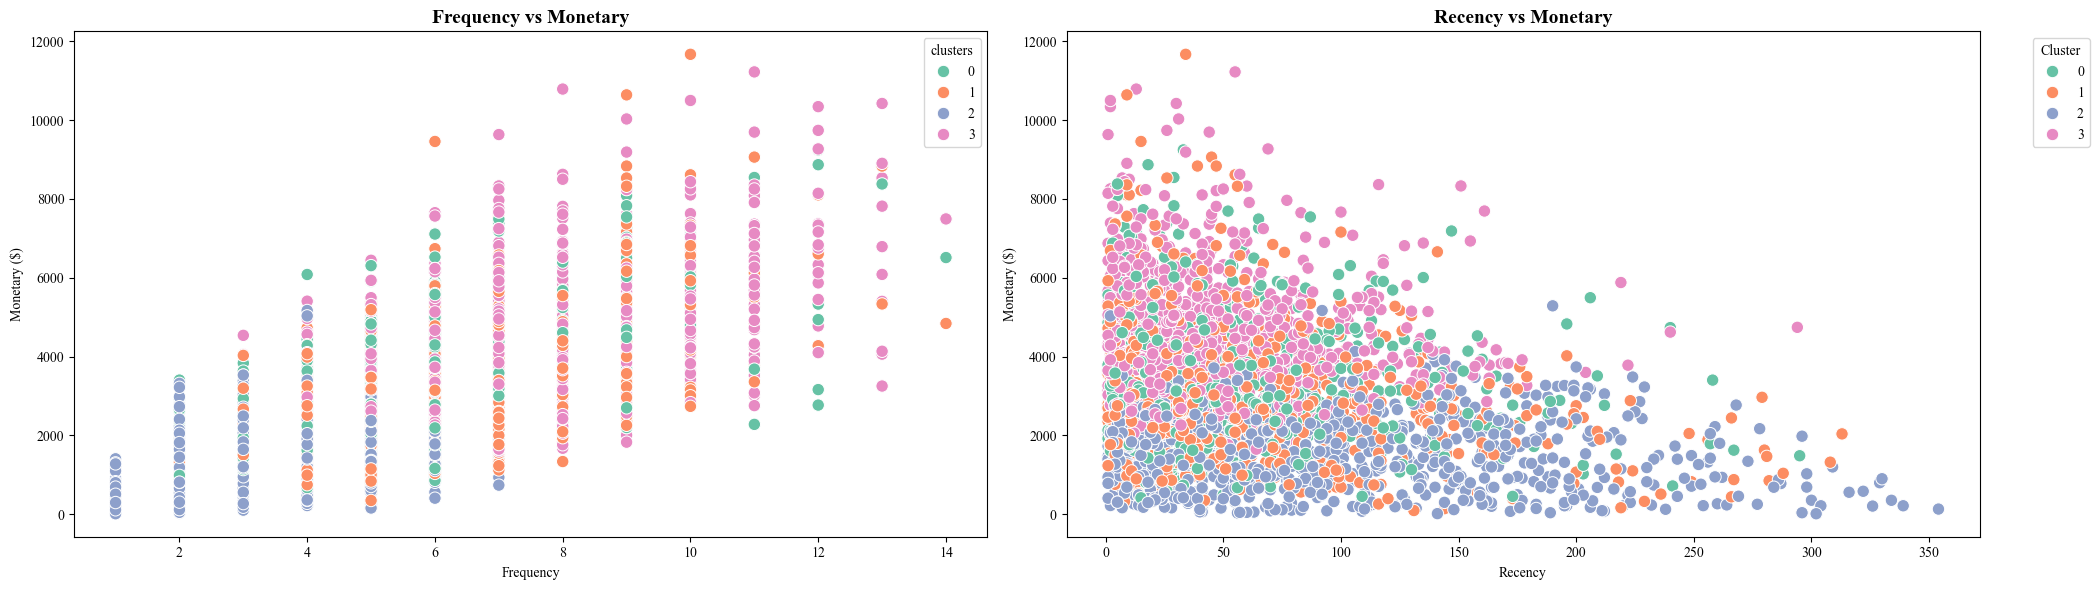

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Scatter plot 1: Frequency vs Monetary
sns.scatterplot(
    data=customerdata_merge,
    x='frequency',
    y='monetary',
    hue='clusters',
    palette='Set2',
    ax=axes[0],
    s=80  # kích thước điểm
)
axes[0].set_title('Frequency vs Monetary', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Monetary ($)')

# Scatter plot 2: Recency vs Monetary
sns.scatterplot(
    data=customerdata_merge,
    x='recency',
    y='monetary',
    hue='clusters',
    palette='Set2',
    ax=axes[1],
    s=80
)
axes[1].set_title('Recency vs Monetary', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Monetary ($)')

# Canh chỉnh bố cục và legend
plt.tight_layout()
axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
